## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

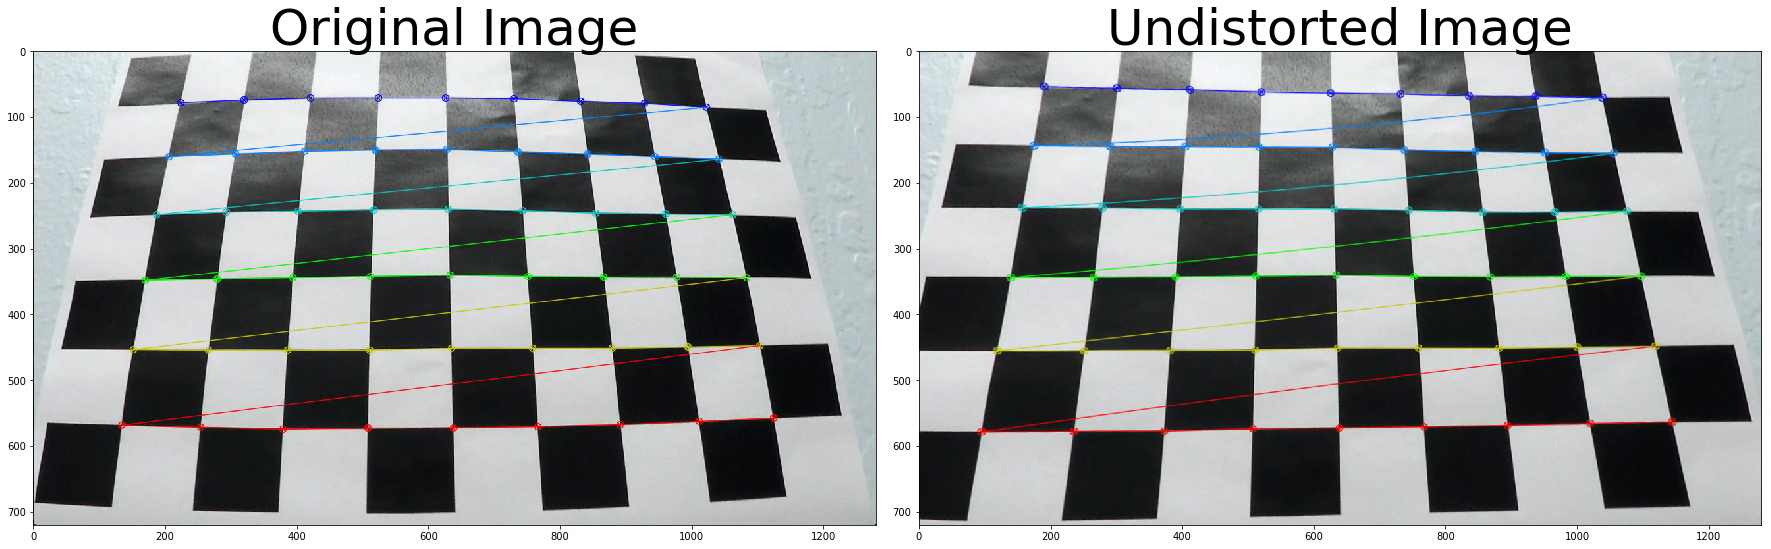

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML

nx = 9
ny = 6
objpoints = []
imgpoints = []
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#Finding in mtx, dst
img = cv2.imread('camera_cal/calibration3.jpg')

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)
    print(ret)
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Undistorted image ## Provide an example of a distortion corrected calibration image. (Chessboard)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite('undistorted_images/calibration3.jpg',undistorted)

### Apply a distortion correction to raw images

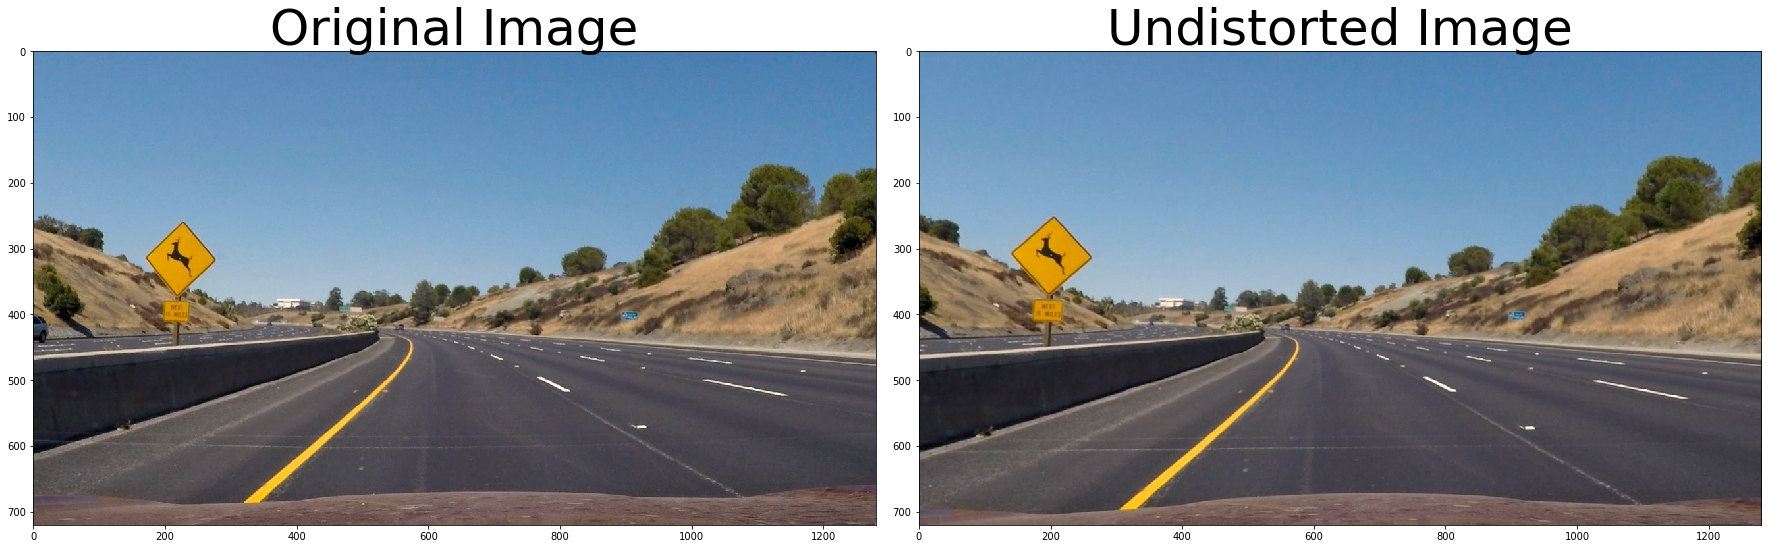

In [2]:
# Example of undistortion on test images
img = cv2.imread('test_images/test2.jpg') #TODO: try and save
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #imread reads in BGR

undistorted = cv2.undistort(img, mtx, dist, None, mtx)

undistorted_save = cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR) #imwrite saves in BGR
cv2.imwrite('undistorted_images/test2.jpg',undistorted_save)

#Plot the difference
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#img --> RGB
#undistorted -->RGB

### Use color transforms, gradients, etc., to create a thresholded binary image

In [3]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print('error')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
    grad_binary = np.zeros_like(scaled_sobel)
    # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Apply threshold
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # Apply threshold
    return dir_binary

def combined_sobel_gradient_threshold(img,s_thresh_min=170,s_thresh_max=255): #150 255
    # Choose a Sobel kernel size
    ksize = 9 # Choose a larger odd number to smooth gradient measurements
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Apply each of the thresholding functions (gradient, magnitude and direction)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 100)) #20 100
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 100)) #20 100
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(70, 100)) # 30 100
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3)) # 0.7 1.3
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # HLS Threshold
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    r_channel = img[:,:,0]

    # Threshold color channels
    h_thresh_min = 15 
    h_thresh_max = 50
    h_binary = np.zeros_like(s_channel)
    h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    r_thresh_min = 220
    r_thresh_max = 255
    r_binary = np.zeros_like(s_channel)
    r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1)  | (r_binary == 1) | (combined == 1)] = 1 #& (h_binary == 1)

    '''
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(12, 6))
    f.tight_layout()
    ax1.imshow(img) # img is RGB
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude and Direction Threshold', fontsize=10)
    ax3.imshow(combined_binary, cmap='gray')
    ax3.set_title('overall Threshold', fontsize=10)
    ax4.imshow(h_binary, cmap='gray')
    ax4.set_title('h Threshold', fontsize=10)
    ax5.imshow(s_binary, cmap='gray')
    ax5.set_title('s Threshold', fontsize=10)
    ax6.imshow(r_binary, cmap='gray')
    ax6.set_title('r Threshold', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    '''
    return combined_binary, img

In [4]:
# Test on example image

fname = 'undistorted_images/test4.jpg'
img = cv2.imread(fname) #Read as BGR it is immediately covnerted into RGB at the beginning of combined_sobel_gradient_threshold function
combined_binary, img = combined_sobel_gradient_threshold(img, s_thresh_min=170,s_thresh_max=255) #binary and RGB

#TODO: Add plots for HLS channels

### Apply a perspective transform to rectify binary image ("birds-eye view")

In [5]:
# Define Source and Destination Points
def transform_image(combined_binary): #takes RGB img and binary combined_binary
    leftupperpoint  = [568,470]
    rightupperpoint = [717,470]
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1043,680]
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])
    
    src_coordinates = np.float32(
    [[280,  700],  # Bottom left
     [595,  460],  # Top left
     [725,  460],  # Top right
     [1125, 700]]) # Bottom right

    dst_coordinates = np.float32(
    [[250,  720],  # Bottom left
     [250,    0],  # Top left
     [1065,   0],  # Top right
     [1065, 720]]) # Bottom right

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped_binary = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR) #binary
    warped_color = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR) #RGB

    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# From now on undistorted image is set to RGB
    #warped_color = cv2.cvtColor(warped_color, cv2.COLOR_BGR2RGB)#RGB
    return warped_binary, warped_color, M, Minv



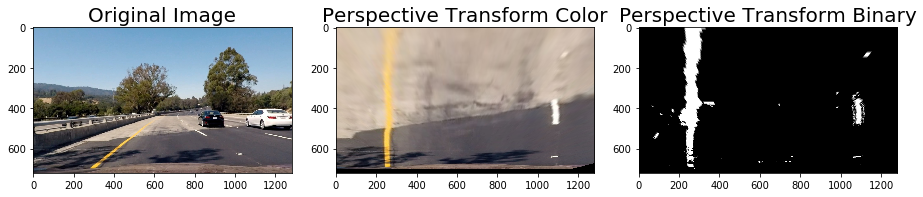

In [6]:
#TODO: Add selected polygons here for writeup
warped_binary, warped_color, M, Minv = transform_image(combined_binary) #in binary
#Plot the difference
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
f.tight_layout()
ax1.imshow(img) # img is RGB
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(warped_color, cmap='gray')
ax2.set_title('Perspective Transform Color', fontsize=20)

ax3.imshow(warped_binary, cmap='gray')
ax3.set_title('Perspective Transform Binary', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#img --> RGB
#warped_color -->RGB
#warped_binary -->binary

### Detect lane pixels and fit to find the lane boundary.

In [7]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #print(leftx,lefty)
    #print(rightx,righty)
    

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #print(left_fitx)
    #print(right_fitx)

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, ploty




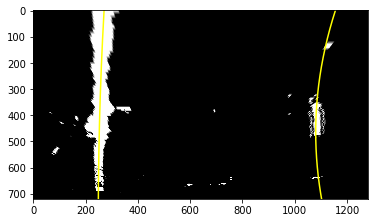

In [8]:
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, ploty = fit_polynomial(warped_binary)

# Plo the fitted polynom and warped binary image
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(warped_binary, cmap='gray')


# Radius of Curvature

In [9]:
def radius_curvature(binary_warped, left_fit, right_fit, left_fitx, right_fitx):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curvature =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center = "Vehicle is {:.2f}m {}".format(center, position)
    
    # Now our radius of curvature is in meters
    return left_curvature, right_curvature, center 

In [10]:
left_curvature, right_curvature, center = radius_curvature(warped_binary, left_fit, right_fit, left_fitx, right_fitx)
print(left_curvature, right_curvature, center)

4577.70460667 474.140379782 Vehicle is 0.39m right


### Warp the detected lane boundaries back onto the original image

In [11]:
def draw_on_image(undist, warped_img, left_fit, right_fit, left_fitx, right_fitx, ploty, M, left_curvature, right_curvature, center, show_values = False):
    #ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero)) #we should make it one channel
    #print(color_warp.shape)
    color_warp = np.zeros_like(warped_img).astype(np.uint8)
    #print(color_warp)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, '{}'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    if show_values == True:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(result)
        
    return result



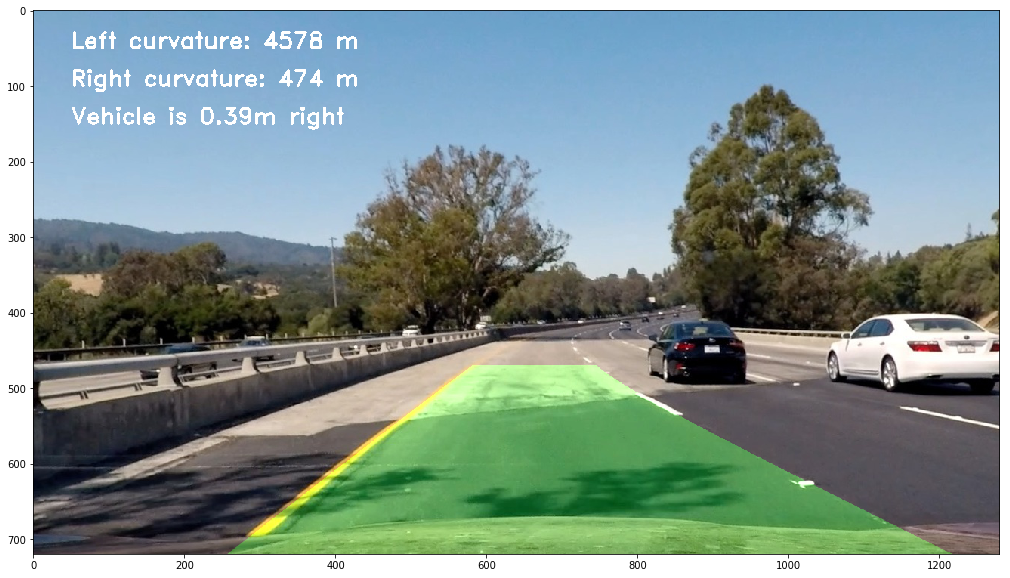

In [12]:
result = draw_on_image(img, warped_color, left_fit, right_fit, left_fitx, right_fitx, ploty, M, left_curvature, right_curvature, center, True)

### Sanity Check

In [13]:
def sanity_check(left_fit, right_fit, left_fitx, right_fitx,left_curvature, right_curvature):
    #Check if left and right fit returned a value
    if len(left_fit) == 0 or len(right_fit) == 0:
        sanity = False
    '''
    ploty = np.linspace(0, 20, num=10 )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    distance = np.mean(right_fitx - left_fitx)
    distance = np.mean(left_fitx-right_fitx)
    print(distance)
    if distance >=160 and distance <=450:
        sanity = True
    else:
        sanity = False
    '''    
    if left_curvature < 400 or left_curvature > 8000 or right_curvature < 400 or right_curvature > 8000:
        sanity = False
    else:
        sanity = True
    # TODO: Might require more sanity checks
    print(sanity)
    return sanity
sanity_check(left_fit, right_fit, left_fitx, right_fitx,left_curvature, right_curvature)
        
        
        
        

True


True

In [25]:
class ProcessLine():
    def __init__(self, img):
        self.last_left_fitx = None
        self.last_right_fitx = None
        self.last_left_fit = None
        self.last_right_fit = None
        self.last_ploty = None
        
        self.left_fit = None
        self.right_fit = None
        self.counter = 0
        self.reset_counter = 0
        self.left_fitx = None
        self.right_fitx = None 
        self.ploty = None
        

        
    #lane =Lane()
    def __call__(self, img):
        #Undistort the imae wih camera calibration matrix M
        undistorted = cv2.undistort(img, mtx, dist, None, mtx)

        #Apply thresholding to get binary image, takes BGR undistorted image and results binary and RGB image
        combined_binary, img = combined_sobel_gradient_threshold(undistorted, s_thresh_min=170,s_thresh_max=255)

        #Apply perspecive transform
        warped_binary, warped_color, M, Minv = transform_image(combined_binary)

        #Detect line pixels and apply polynomial fit
        out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, ploty = fit_polynomial(warped_binary)
        
        
        #Calculate curvature radius
        left_curvature, right_curvature, center = radius_curvature(warped_binary, left_fit, right_fit, left_fitx, right_fitx)
        print(left_curvature,right_curvature)
        if left_curvature < 500 or left_curvature > 8000 or right_curvature < 500 or right_curvature > 8000:
            sanity = False
            print('using previous frame data')
            left_fitx = self.last_left_fitx
            right_fitx = self.last_right_fitx 
            left_fit = self.last_left_fit
            right_fit = self.last_right_fitx
            ploty = self.last_ploty
        else:
            sanity = True
            self.last_left_fitx = left_fitx
            self.last_right_fitx = right_fitx
            self.last_left_fit = left_fit
            self.last_right_fit = right_fit
            self.last_ploty = ploty
        

        #Apply computer vision steps into original image
        result = draw_on_image(img, warped_color, left_fit, right_fit, left_fitx, right_fitx, ploty, M, left_curvature,
                      right_curvature, center, False)
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        '''
        img = cv2.imread('test_images/test1.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pipeline(img)
        plt.imshow(result)
        '''
        return result

### Video Processing

In [26]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

## You may uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(input_video).subclip(38,45)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ProcessLine('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(output_video, audio=False)

1017.14156862 2744.0015537
[MoviePy] >>>> Building video ./project_video_solution.mp4
[MoviePy] Writing video ./project_video_solution.mp4


  0%|          | 1/1261 [00:00<05:28,  3.83it/s]

1017.14156862 2744.0015537


  0%|          | 2/1261 [00:00<05:31,  3.80it/s]

883.671037312 1238.30081441


  0%|          | 3/1261 [00:00<05:25,  3.87it/s]

740.237622208 777.459675381


  0%|          | 4/1261 [00:01<05:18,  3.95it/s]

693.035992861 1046.085496


  0%|          | 5/1261 [00:01<05:15,  3.98it/s]

741.363151171 829.378238615


  0%|          | 6/1261 [00:01<05:12,  4.02it/s]

774.36738606 1244.12094528


  1%|          | 7/1261 [00:01<05:09,  4.06it/s]

761.988017391 1506.8480492


  1%|          | 8/1261 [00:01<05:06,  4.09it/s]

769.211545548 847.873299898


  1%|          | 9/1261 [00:02<05:03,  4.13it/s]

885.959800306 408.804853638
using previous frame data


  1%|          | 10/1261 [00:02<05:02,  4.14it/s]

934.550135985 426.56201442
using previous frame data


  1%|          | 11/1261 [00:02<05:01,  4.15it/s]

871.930265769 738.147719566


  1%|          | 12/1261 [00:02<05:00,  4.15it/s]

936.764251833 911.63496632


  1%|          | 13/1261 [00:03<05:01,  4.14it/s]

911.196354941 1736.52890783


  1%|          | 14/1261 [00:03<05:02,  4.13it/s]

938.116170259 760.951012372


  1%|          | 15/1261 [00:03<05:02,  4.12it/s]

887.67502224 702.413804317


  1%|▏         | 16/1261 [00:03<04:59,  4.15it/s]

880.92926561 803.149113782


  1%|▏         | 17/1261 [00:04<05:00,  4.14it/s]

954.336329524 1944.01168557


  1%|▏         | 18/1261 [00:04<04:59,  4.14it/s]

1204.31662714 3814.34894949


  2%|▏         | 19/1261 [00:04<05:00,  4.13it/s]

1160.64915114 9831.77577278
using previous frame data


  2%|▏         | 20/1261 [00:04<04:57,  4.17it/s]

1515.06460355 4883.31314003


  2%|▏         | 21/1261 [00:05<04:56,  4.18it/s]

1783.81438447 2193.60845094


  2%|▏         | 22/1261 [00:05<04:56,  4.18it/s]

2124.5831988 573.82872592


  2%|▏         | 23/1261 [00:05<04:56,  4.18it/s]

2322.48011849 405.852561562
using previous frame data


  2%|▏         | 24/1261 [00:05<04:56,  4.17it/s]

2415.28266246 531.026259924


  2%|▏         | 25/1261 [00:06<04:56,  4.17it/s]

1700.74054927 1103.39736175


  2%|▏         | 26/1261 [00:06<04:56,  4.17it/s]

1747.31684081 41797.6623376
using previous frame data


  2%|▏         | 27/1261 [00:06<04:56,  4.17it/s]

1593.88857845 2525.90966655


  2%|▏         | 28/1261 [00:06<04:57,  4.15it/s]

1452.6000989 1168.33458669


  2%|▏         | 29/1261 [00:07<04:56,  4.15it/s]

1162.93481975 1629.87092009


  2%|▏         | 30/1261 [00:07<05:00,  4.10it/s]

1127.83308967 965.428473167


  2%|▏         | 31/1261 [00:07<05:01,  4.08it/s]

996.153287289 1199.32020203


  3%|▎         | 32/1261 [00:07<05:01,  4.08it/s]

859.260320876 1883.33699609


  3%|▎         | 33/1261 [00:08<04:57,  4.13it/s]

906.958247754 2100.64202101


  3%|▎         | 34/1261 [00:08<04:57,  4.12it/s]

879.702342535 543.936591731


  3%|▎         | 35/1261 [00:08<04:56,  4.13it/s]

873.276974167 387.781327163
using previous frame data


  3%|▎         | 36/1261 [00:08<04:56,  4.13it/s]

836.041784276 507.893264369


  3%|▎         | 37/1261 [00:08<04:55,  4.14it/s]

820.857698778 1099.28160368


  3%|▎         | 38/1261 [00:09<04:56,  4.13it/s]

775.46530168 935.054661503


  3%|▎         | 39/1261 [00:09<04:55,  4.13it/s]

713.370131288 731.664437923


  3%|▎         | 40/1261 [00:09<04:55,  4.13it/s]

680.97468212 890.193187635


  3%|▎         | 41/1261 [00:09<04:56,  4.12it/s]

643.477867321 1103.31817692


  3%|▎         | 42/1261 [00:10<04:53,  4.15it/s]

637.418356586 1410.83860733


  3%|▎         | 43/1261 [00:10<06:26,  3.15it/s]

663.255640302 1297.59002332


  3%|▎         | 44/1261 [00:11<06:27,  3.14it/s]

668.157825243 1302.56900233


  4%|▎         | 45/1261 [00:11<06:58,  2.91it/s]

706.391370065 2103.78786236


  4%|▎         | 46/1261 [00:11<06:57,  2.91it/s]

699.906347673 1795.99628636


  4%|▎         | 47/1261 [00:12<06:38,  3.04it/s]

714.28903686 471.087843039
using previous frame data


  4%|▍         | 48/1261 [00:12<06:40,  3.03it/s]

700.474308111 412.313317652
using previous frame data


  4%|▍         | 49/1261 [00:12<06:26,  3.13it/s]

710.797645541 714.986456594


  4%|▍         | 50/1261 [00:13<06:35,  3.06it/s]

718.43945587 805.445541126


  4%|▍         | 51/1261 [00:13<06:22,  3.16it/s]

742.904612305 5422.41294895


  4%|▍         | 52/1261 [00:13<06:28,  3.12it/s]

740.788602539 1713.79502812


  4%|▍         | 53/1261 [00:13<06:18,  3.19it/s]

793.617108466 852.131989623


  4%|▍         | 54/1261 [00:14<06:26,  3.12it/s]

798.88591941 1323.47200184


  4%|▍         | 55/1261 [00:14<06:18,  3.18it/s]

979.345545275 1214.71402683


  4%|▍         | 56/1261 [00:14<06:32,  3.07it/s]

1136.57500022 1094.16338762


  5%|▍         | 57/1261 [00:15<06:22,  3.15it/s]

1248.82664372 2219.94061762


  5%|▍         | 58/1261 [00:15<06:28,  3.09it/s]

1609.21651739 2027.37415912


  5%|▍         | 59/1261 [00:15<06:21,  3.15it/s]

1821.20955609 342.287315288
using previous frame data


  5%|▍         | 60/1261 [00:16<06:29,  3.08it/s]

1810.97241426 438.459450407
using previous frame data


  5%|▍         | 61/1261 [00:16<06:21,  3.14it/s]

2205.22308228 870.896590095


  5%|▍         | 62/1261 [00:16<06:26,  3.10it/s]

1675.57293529 2488.7484578


  5%|▍         | 63/1261 [00:17<06:18,  3.17it/s]

1633.77344711 10074.6750322
using previous frame data


  5%|▌         | 64/1261 [00:17<06:23,  3.12it/s]

1300.62110687 1002.78504971


  5%|▌         | 65/1261 [00:17<06:26,  3.10it/s]

1212.06409637 815.9457803


  5%|▌         | 66/1261 [00:18<06:16,  3.18it/s]

917.287471603 3446.36561777


  5%|▌         | 67/1261 [00:18<06:24,  3.10it/s]

876.83770396 3023.80277257


  5%|▌         | 68/1261 [00:18<06:23,  3.11it/s]

924.295301179 3306.39531578


  5%|▌         | 69/1261 [00:19<06:25,  3.09it/s]

847.153465231 150398.657481
using previous frame data


  6%|▌         | 70/1261 [00:19<06:29,  3.06it/s]

772.030802884 10665.6364831
using previous frame data


  6%|▌         | 71/1261 [00:19<06:18,  3.15it/s]

789.187196576 417.24687574
using previous frame data


  6%|▌         | 72/1261 [00:20<06:21,  3.12it/s]

791.334689779 474.492777717
using previous frame data


  6%|▌         | 73/1261 [00:20<06:28,  3.06it/s]

857.80587011 617.498820033


  6%|▌         | 74/1261 [00:20<06:28,  3.06it/s]

1014.40094372 961.539760299


  6%|▌         | 75/1261 [00:21<06:31,  3.03it/s]

1111.51345931 2363.63229863


  6%|▌         | 76/1261 [00:21<06:20,  3.12it/s]

1179.13788536 8225.83184596
using previous frame data


  6%|▌         | 77/1261 [00:21<06:28,  3.05it/s]

1522.86031437 2338.63581079


  6%|▌         | 78/1261 [00:21<06:16,  3.14it/s]

1838.89028423 1519.44783525


  6%|▋         | 79/1261 [00:22<06:26,  3.06it/s]

1731.98325535 1166.01147837


  6%|▋         | 80/1261 [00:22<06:15,  3.15it/s]

1586.30698557 1885.40904652


  6%|▋         | 81/1261 [00:22<06:21,  3.09it/s]

3217.96718782 1359.9366113


  7%|▋         | 82/1261 [00:23<06:12,  3.16it/s]

3305.54852332 1830.50037561


  7%|▋         | 83/1261 [00:23<06:19,  3.10it/s]

3097.23596447 2390.71743938


  7%|▋         | 84/1261 [00:23<06:08,  3.19it/s]

3922.16600878 4231.02972669


  7%|▋         | 85/1261 [00:24<06:09,  3.18it/s]

3344.19705217 679.59963476


  7%|▋         | 86/1261 [00:24<06:12,  3.15it/s]

3151.04220072 420.002110119
using previous frame data


  7%|▋         | 87/1261 [00:24<06:13,  3.15it/s]

2117.17632594 717.714234206


  7%|▋         | 88/1261 [00:25<06:17,  3.10it/s]

1777.87171793 20147.7982777
using previous frame data


  7%|▋         | 89/1261 [00:25<06:08,  3.18it/s]

1532.34485333 1036.91813856


  7%|▋         | 90/1261 [00:25<06:18,  3.09it/s]

1178.48681166 885.13998117


  7%|▋         | 91/1261 [00:26<06:11,  3.15it/s]

1105.57428913 896.479817445


  7%|▋         | 92/1261 [00:26<06:17,  3.10it/s]

1020.65829332 4105.78331661


  7%|▋         | 93/1261 [00:26<06:06,  3.19it/s]

975.962754401 2575.34531877


  7%|▋         | 94/1261 [00:27<06:08,  3.17it/s]

946.794433017 4203.58666568


  8%|▊         | 95/1261 [00:27<06:12,  3.13it/s]

904.202856576 4831.06124631


  8%|▊         | 96/1261 [00:27<06:01,  3.23it/s]

879.28558354 638.795617144


  8%|▊         | 97/1261 [00:28<06:05,  3.18it/s]

913.195022699 394.364557926
using previous frame data


  8%|▊         | 98/1261 [00:28<06:32,  2.96it/s]

953.868223743 434.754553055
using previous frame data


  8%|▊         | 99/1261 [00:28<06:26,  3.01it/s]

988.723092634 716.841469902


  8%|▊         | 100/1261 [00:29<06:21,  3.04it/s]

1047.65190251 1228.58234606


  8%|▊         | 101/1261 [00:29<06:19,  3.06it/s]

1013.68608301 3274.18583749


  8%|▊         | 102/1261 [00:29<06:15,  3.09it/s]

983.532620172 1431.17848549


  8%|▊         | 103/1261 [00:30<06:16,  3.08it/s]

1027.85564868 1434.22809005


  8%|▊         | 104/1261 [00:30<06:13,  3.10it/s]

1022.4776386 2988.45506572


  8%|▊         | 105/1261 [00:30<06:28,  2.98it/s]

953.106160186 1512.54492464


  8%|▊         | 106/1261 [00:31<06:14,  3.09it/s]

1090.72042371 892.586429611


  8%|▊         | 107/1261 [00:31<06:18,  3.05it/s]

1075.65480646 1121.91721773


  9%|▊         | 108/1261 [00:31<06:05,  3.16it/s]

1040.91425167 2151.64329358


  9%|▊         | 109/1261 [00:31<06:08,  3.12it/s]

1038.18532293 3618.30094643


  9%|▊         | 110/1261 [00:32<05:57,  3.22it/s]

1033.33152716 590.756987886


  9%|▉         | 111/1261 [00:32<06:04,  3.15it/s]

962.895124248 445.087414534
using previous frame data


  9%|▉         | 112/1261 [00:32<05:54,  3.24it/s]

988.464640689 583.614517982


  9%|▉         | 113/1261 [00:33<06:03,  3.16it/s]

911.867383229 907.831945623


  9%|▉         | 114/1261 [00:33<05:54,  3.23it/s]

967.900166502 4215.31907922


  9%|▉         | 115/1261 [00:33<06:03,  3.15it/s]

860.438193658 1842.84621729


  9%|▉         | 116/1261 [00:34<05:54,  3.23it/s]

866.489861409 1050.83567414


  9%|▉         | 117/1261 [00:34<06:00,  3.17it/s]

819.029886749 1453.3658907


  9%|▉         | 118/1261 [00:34<05:52,  3.24it/s]

888.808751398 1119.80046341


  9%|▉         | 119/1261 [00:35<05:57,  3.20it/s]

893.279883895 1167.15733565


 10%|▉         | 120/1261 [00:35<06:10,  3.08it/s]

830.186840936 1354.30854996


 10%|▉         | 121/1261 [00:35<06:08,  3.09it/s]

832.613864641 627.74733344


 10%|▉         | 122/1261 [00:36<06:04,  3.13it/s]

817.403819368 310.606628185
using previous frame data


 10%|▉         | 123/1261 [00:36<06:02,  3.14it/s]

761.728239646 509.739262438


 10%|▉         | 124/1261 [00:36<06:00,  3.16it/s]

774.748832917 681.854638355


 10%|▉         | 125/1261 [00:36<05:58,  3.17it/s]

761.849456106 1071.69645599


 10%|▉         | 126/1261 [00:37<06:00,  3.15it/s]

776.761586823 2923.68173215


 10%|█         | 127/1261 [00:37<05:50,  3.24it/s]

780.82412997 1363.56278404


 10%|█         | 128/1261 [00:37<05:53,  3.20it/s]

794.241781898 1970.80669306


 10%|█         | 129/1261 [00:38<05:58,  3.15it/s]

702.898861835 2521.05132244


 10%|█         | 130/1261 [00:38<05:59,  3.15it/s]

759.669211312 1159.96633811


 10%|█         | 131/1261 [00:38<05:57,  3.16it/s]

835.10205287 1350.63985518


 10%|█         | 132/1261 [00:39<05:59,  3.14it/s]

838.404631954 1633.31344246


 11%|█         | 133/1261 [00:39<06:02,  3.11it/s]

883.402821369 1428.36865347


 11%|█         | 134/1261 [00:39<06:01,  3.12it/s]

936.157312204 313.022872482
using previous frame data


 11%|█         | 135/1261 [00:40<06:05,  3.08it/s]

967.634589009 387.148507924
using previous frame data


 11%|█         | 136/1261 [00:40<05:55,  3.17it/s]

1069.02773048 822.905595204


 11%|█         | 137/1261 [00:40<06:00,  3.12it/s]

1094.39322272 707.401986489


 11%|█         | 138/1261 [00:41<05:51,  3.19it/s]

1145.9454233 945.353085734


 11%|█         | 139/1261 [00:41<05:57,  3.14it/s]

1158.68139921 6958.66931138


 11%|█         | 140/1261 [00:41<05:48,  3.22it/s]

1127.00590427 1404.85684534


 11%|█         | 141/1261 [00:42<05:49,  3.20it/s]

1087.62386472 1308.36831911


 11%|█▏        | 142/1261 [00:42<05:56,  3.14it/s]

1081.24151837 1197.43155369


 11%|█▏        | 143/1261 [00:42<05:55,  3.15it/s]

1081.45839568 1196.25204636


 11%|█▏        | 144/1261 [00:43<05:55,  3.14it/s]

1009.44677799 2077.56230207


 11%|█▏        | 145/1261 [00:43<05:55,  3.14it/s]

1000.39007821 1714.8634864


 12%|█▏        | 146/1261 [00:43<05:55,  3.13it/s]

1006.90192109 3256.43265084


 12%|█▏        | 147/1261 [00:43<05:54,  3.14it/s]

1041.35509125 482.092878034
using previous frame data


 12%|█▏        | 148/1261 [00:44<05:54,  3.14it/s]

1069.95586804 810.964713691


 12%|█▏        | 149/1261 [00:44<05:57,  3.11it/s]

1125.26666435 1652.01226408


 12%|█▏        | 150/1261 [00:44<06:03,  3.06it/s]

1283.09508327 3090.35662539


 12%|█▏        | 151/1261 [00:45<05:51,  3.16it/s]

1285.48226173 2402.08815838


 12%|█▏        | 152/1261 [00:45<05:54,  3.12it/s]

1413.40422921 860.088324239


 12%|█▏        | 153/1261 [00:45<05:43,  3.22it/s]

1323.18929518 1102.57732996


 12%|█▏        | 154/1261 [00:46<05:48,  3.18it/s]

1261.02331918 1508.15708153


 12%|█▏        | 155/1261 [00:46<05:43,  3.22it/s]

1521.99143273 2065.9851588


 12%|█▏        | 156/1261 [00:46<05:47,  3.18it/s]

1592.57726937 964.549266177


 12%|█▏        | 157/1261 [00:47<05:52,  3.13it/s]

1346.89647535 1431.17994965


 13%|█▎        | 158/1261 [00:47<05:53,  3.12it/s]

1317.68148983 1030.83669169


 13%|█▎        | 159/1261 [00:47<05:53,  3.12it/s]

1202.27043326 398.549840634
using previous frame data


 13%|█▎        | 160/1261 [00:48<05:51,  3.13it/s]

1062.3702792 449.20058259
using previous frame data


 13%|█▎        | 161/1261 [00:48<05:50,  3.14it/s]

1028.61458345 550.676464824


 13%|█▎        | 162/1261 [00:48<05:49,  3.15it/s]

972.464102592 1092.89425305


 13%|█▎        | 163/1261 [00:49<05:54,  3.09it/s]

1043.66482893 1827.73887585


 13%|█▎        | 164/1261 [00:49<05:50,  3.13it/s]

946.548205707 1032.82021385


 13%|█▎        | 165/1261 [00:49<05:54,  3.09it/s]

852.285665091 675.398334639


 13%|█▎        | 166/1261 [00:50<05:43,  3.18it/s]

824.933555899 768.898670904


 13%|█▎        | 167/1261 [00:50<05:49,  3.13it/s]

811.662470703 10597.7954809
using previous frame data


 13%|█▎        | 168/1261 [00:50<05:38,  3.23it/s]

1020.8610574 4123.95950912


 13%|█▎        | 169/1261 [00:50<05:45,  3.16it/s]

861.294232233 5888.16206718


 13%|█▎        | 170/1261 [00:51<05:36,  3.25it/s]

947.710695428 32510.5854636
using previous frame data


 14%|█▎        | 171/1261 [00:51<05:43,  3.17it/s]

995.074247307 20939.9781361
using previous frame data


 14%|█▎        | 172/1261 [00:51<05:34,  3.26it/s]

977.225908878 594.110593706


 14%|█▎        | 173/1261 [00:52<05:40,  3.19it/s]

1074.88708923 423.588070022
using previous frame data


 14%|█▍        | 174/1261 [00:52<05:31,  3.28it/s]

1188.02002132 699.757131264


 14%|█▍        | 175/1261 [00:52<05:38,  3.21it/s]

1382.40357264 1513.41778115


 14%|█▍        | 176/1261 [00:53<05:31,  3.27it/s]

1516.3352567 2947.81711604


 14%|█▍        | 177/1261 [00:53<05:35,  3.23it/s]

1791.86616606 2044.27373655


 14%|█▍        | 178/1261 [00:53<05:50,  3.09it/s]

1854.04791078 3807.55983353


 14%|█▍        | 179/1261 [00:54<05:50,  3.09it/s]

1698.20347576 5758.72245596


 14%|█▍        | 180/1261 [00:54<05:52,  3.06it/s]

2142.96983397 712.924788785


 14%|█▍        | 181/1261 [00:54<05:54,  3.05it/s]

1756.01725005 682.186430038


 14%|█▍        | 182/1261 [00:55<05:40,  3.16it/s]

1381.66570618 731.879409227


 15%|█▍        | 183/1261 [00:55<05:41,  3.15it/s]

1235.09842948 478.585502736
using previous frame data


 15%|█▍        | 184/1261 [00:55<05:47,  3.10it/s]

963.260533278 317.276935796
using previous frame data


 15%|█▍        | 185/1261 [00:56<05:46,  3.11it/s]

867.633646471 476.485212054
using previous frame data


 15%|█▍        | 186/1261 [00:56<05:49,  3.08it/s]

682.419412193 1492.79827465


 15%|█▍        | 187/1261 [00:56<05:37,  3.19it/s]

641.851018747 3009.80326141


 15%|█▍        | 188/1261 [00:56<05:45,  3.11it/s]

606.498153031 1082.0479957


 15%|█▍        | 189/1261 [00:57<05:36,  3.18it/s]

579.496473705 1147.24964876


 15%|█▌        | 190/1261 [00:57<05:40,  3.14it/s]

572.025830926 1583.36203718


 15%|█▌        | 191/1261 [00:57<05:44,  3.10it/s]

572.969058404 1369.75461683


 15%|█▌        | 192/1261 [00:58<05:46,  3.09it/s]

670.956865702 1535.32054886


 15%|█▌        | 193/1261 [00:58<05:49,  3.05it/s]

686.239962664 1209.41283429


 15%|█▌        | 194/1261 [00:58<05:48,  3.06it/s]

711.463786617 670.950874403


 15%|█▌        | 195/1261 [00:59<05:49,  3.05it/s]

743.714953017 521.341425333


 16%|█▌        | 196/1261 [00:59<05:37,  3.15it/s]

805.466694406 349.115029765
using previous frame data


 16%|█▌        | 197/1261 [00:59<05:47,  3.06it/s]

907.363839959 387.545856028
using previous frame data


 16%|█▌        | 198/1261 [01:00<05:36,  3.16it/s]

883.795029005 420.367088288
using previous frame data


 16%|█▌        | 199/1261 [01:00<05:42,  3.10it/s]

909.323819753 473.058383976
using previous frame data


 16%|█▌        | 200/1261 [01:00<05:32,  3.19it/s]

973.377066716 700.388836278


 16%|█▌        | 201/1261 [01:01<05:37,  3.14it/s]

1045.59565567 2009.74772536


 16%|█▌        | 202/1261 [01:01<05:29,  3.22it/s]

962.114777683 3381.57027228


 16%|█▌        | 203/1261 [01:01<05:35,  3.15it/s]

954.046534906 1482.90995557


 16%|█▌        | 204/1261 [01:02<05:33,  3.17it/s]

987.739725371 1943.43562905


 16%|█▋        | 205/1261 [01:02<06:51,  2.56it/s]

1146.62897827 1152.18804649


 16%|█▋        | 206/1261 [01:03<07:31,  2.34it/s]

1136.34461693 1235.38300745


 16%|█▋        | 207/1261 [01:03<07:01,  2.50it/s]

1033.41142843 1134.33230948


 16%|█▋        | 208/1261 [01:03<06:27,  2.72it/s]

984.35275296 338.684378733
using previous frame data


 17%|█▋        | 209/1261 [01:04<06:20,  2.76it/s]

1037.0441262 358.41648762
using previous frame data


 17%|█▋        | 210/1261 [01:04<06:02,  2.90it/s]

1060.50228174 456.437682888
using previous frame data


 17%|█▋        | 211/1261 [01:04<05:57,  2.93it/s]

1059.17964541 628.615391121


 17%|█▋        | 212/1261 [01:05<05:40,  3.08it/s]

920.091675643 1008.59603047


 17%|█▋        | 213/1261 [01:05<05:44,  3.05it/s]

852.928385571 2708.16450872


 17%|█▋        | 214/1261 [01:05<05:31,  3.16it/s]

746.856243124 2233.19422401


 17%|█▋        | 215/1261 [01:06<05:35,  3.12it/s]

690.150376618 1514.87918085


 17%|█▋        | 216/1261 [01:06<05:26,  3.20it/s]

663.81727381 1886.25184347


 17%|█▋        | 217/1261 [01:06<05:30,  3.15it/s]

719.93644629 968.642638888


 17%|█▋        | 218/1261 [01:06<05:22,  3.23it/s]

710.449120989 1031.32715008


 17%|█▋        | 219/1261 [01:07<05:30,  3.15it/s]

734.317736633 1400.14163552


 17%|█▋        | 220/1261 [01:07<05:23,  3.22it/s]

784.580477414 1458.61112937


 18%|█▊        | 221/1261 [01:07<05:28,  3.16it/s]

811.136351601 487.308587041
using previous frame data


 18%|█▊        | 222/1261 [01:08<05:22,  3.23it/s]

841.495717375 502.39371251


 18%|█▊        | 223/1261 [01:08<05:29,  3.15it/s]

949.929807609 745.215720546


 18%|█▊        | 224/1261 [01:08<05:56,  2.91it/s]

863.1465757 1873.11449597


 18%|█▊        | 225/1261 [01:09<05:48,  2.97it/s]

930.079753999 5527.12157543


 18%|█▊        | 226/1261 [01:09<05:49,  2.96it/s]

948.089850556 764.70214657


 18%|█▊        | 227/1261 [01:09<05:36,  3.08it/s]

853.205808639 705.206019141


 18%|█▊        | 228/1261 [01:10<05:39,  3.05it/s]

859.170985568 919.67950617


 18%|█▊        | 229/1261 [01:10<05:28,  3.14it/s]

997.885185325 8392.62332495
using previous frame data


 18%|█▊        | 230/1261 [01:10<05:32,  3.10it/s]

1032.9081716 2166.71625695


 18%|█▊        | 231/1261 [01:11<05:22,  3.19it/s]

1053.82089986 3647.79697851


 18%|█▊        | 232/1261 [01:11<05:29,  3.12it/s]

1219.14542637 3976.02620109


 18%|█▊        | 233/1261 [01:11<05:24,  3.17it/s]

1237.18319541 1235.51150828


 19%|█▊        | 234/1261 [01:12<05:30,  3.11it/s]

1212.65627744 467.861085868
using previous frame data


 19%|█▊        | 235/1261 [01:12<05:19,  3.21it/s]

1277.95159933 534.00187574


 19%|█▊        | 236/1261 [01:12<05:25,  3.15it/s]

1326.16720083 852.608686359


 19%|█▉        | 237/1261 [01:13<05:16,  3.24it/s]

1398.73674074 3023.51132496


 19%|█▉        | 238/1261 [01:13<05:22,  3.17it/s]

1316.9434413 2293.92903312


 19%|█▉        | 239/1261 [01:13<05:38,  3.02it/s]

1226.30468451 2447.2035722


 19%|█▉        | 240/1261 [01:14<05:39,  3.00it/s]

1144.37394404 2905.2382708


 19%|█▉        | 241/1261 [01:14<05:41,  2.99it/s]

1222.99053456 1037.87657595


 19%|█▉        | 242/1261 [01:14<05:28,  3.10it/s]

1256.11824913 951.088207356


 19%|█▉        | 243/1261 [01:15<05:32,  3.07it/s]

1181.51134761 1216.12626643


 19%|█▉        | 244/1261 [01:15<05:22,  3.15it/s]

1128.36539939 1216.19597353


 19%|█▉        | 245/1261 [01:15<05:25,  3.12it/s]

1074.13025763 369.900676898
using previous frame data


 20%|█▉        | 246/1261 [01:15<05:16,  3.21it/s]

1082.70846834 560.819917568


 20%|█▉        | 247/1261 [01:16<05:23,  3.13it/s]

1022.93783093 563.789480207


 20%|█▉        | 248/1261 [01:16<05:15,  3.22it/s]

932.153321248 799.648265014


 20%|█▉        | 249/1261 [01:16<05:21,  3.15it/s]

969.066012105 2522.85322501


 20%|█▉        | 250/1261 [01:17<05:31,  3.05it/s]

921.457107214 2259.53068189


 20%|█▉        | 251/1261 [01:17<05:21,  3.14it/s]

957.499315831 3149.24366153


 20%|█▉        | 252/1261 [01:17<05:30,  3.06it/s]

956.606306315 3242.70764534


 20%|██        | 253/1261 [01:18<05:21,  3.13it/s]

1012.68663893 1318.7743281


 20%|██        | 254/1261 [01:18<05:25,  3.10it/s]

1105.91303222 1425.08689218


 20%|██        | 255/1261 [01:18<05:14,  3.20it/s]

1113.26470165 1498.69406851


 20%|██        | 256/1261 [01:19<05:22,  3.12it/s]

1154.99392234 1695.48706419


 20%|██        | 257/1261 [01:19<05:13,  3.20it/s]

1061.42432436 435.138380563
using previous frame data


 20%|██        | 258/1261 [01:19<05:22,  3.11it/s]

1146.44165842 523.887688748


 21%|██        | 259/1261 [01:20<05:15,  3.17it/s]

1178.02533501 666.186433679


 21%|██        | 260/1261 [01:20<05:24,  3.09it/s]

1169.60702241 1674.0639025


 21%|██        | 261/1261 [01:20<05:15,  3.17it/s]

1179.91272432 2600.55360119


 21%|██        | 262/1261 [01:21<05:23,  3.09it/s]

1179.56623899 1946.267805


 21%|██        | 263/1261 [01:21<05:14,  3.17it/s]

1176.83895654 1505.8409081


 21%|██        | 264/1261 [01:21<05:21,  3.10it/s]

1138.73265884 2168.22297347


 21%|██        | 265/1261 [01:22<05:12,  3.19it/s]

1291.08043703 1661.92732896


 21%|██        | 266/1261 [01:22<05:18,  3.12it/s]

1290.19812226 925.356010007


 21%|██        | 267/1261 [01:22<05:11,  3.19it/s]

1212.40152238 1436.04705564


 21%|██▏       | 268/1261 [01:22<05:18,  3.11it/s]

1187.55763544 1347.10473233


 21%|██▏       | 269/1261 [01:23<05:11,  3.19it/s]

1247.37071841 1310.62009261


 21%|██▏       | 270/1261 [01:23<05:19,  3.10it/s]

1234.04178085 419.413035047
using previous frame data


 21%|██▏       | 271/1261 [01:23<05:11,  3.18it/s]

1163.84907853 526.398551506


 22%|██▏       | 272/1261 [01:24<05:18,  3.10it/s]

1072.21185323 1048.24953039


 22%|██▏       | 273/1261 [01:24<05:09,  3.19it/s]

1062.09514804 2382.27000672


 22%|██▏       | 274/1261 [01:24<05:17,  3.11it/s]

1043.03171742 870.756501868


 22%|██▏       | 275/1261 [01:25<05:08,  3.20it/s]

1098.55946543 851.731758767


 22%|██▏       | 276/1261 [01:25<05:12,  3.15it/s]

1016.44722229 1161.72320631


 22%|██▏       | 277/1261 [01:25<05:02,  3.26it/s]

1261.61582131 2200.20721066


 22%|██▏       | 278/1261 [01:26<05:09,  3.18it/s]

1161.8754498 1308.0255777


 22%|██▏       | 279/1261 [01:26<05:01,  3.26it/s]

1181.27687251 1776.95866557


 22%|██▏       | 280/1261 [01:26<05:10,  3.16it/s]

1203.32825804 1837.3345265


 22%|██▏       | 281/1261 [01:27<05:03,  3.23it/s]

1214.09419484 437.231478507
using previous frame data


 22%|██▏       | 282/1261 [01:27<05:14,  3.12it/s]

1237.68243895 491.648529815
using previous frame data


 22%|██▏       | 283/1261 [01:27<05:06,  3.19it/s]

1326.66590329 729.906038146


 23%|██▎       | 284/1261 [01:28<05:09,  3.16it/s]

1357.42830563 1453.25798816


 23%|██▎       | 285/1261 [01:28<05:08,  3.16it/s]

1378.58190217 4201.5608684


 23%|██▎       | 286/1261 [01:28<05:08,  3.16it/s]

1441.4470366 1980.48344907


 23%|██▎       | 287/1261 [01:28<05:10,  3.14it/s]

1406.41826744 823.491189409


 23%|██▎       | 288/1261 [01:29<05:02,  3.22it/s]

1258.78607437 962.948883302


 23%|██▎       | 289/1261 [01:29<05:10,  3.13it/s]

1507.11375015 1268.45772496


 23%|██▎       | 290/1261 [01:29<05:02,  3.21it/s]

1609.76703927 2275.88154328


 23%|██▎       | 291/1261 [01:30<05:09,  3.14it/s]

1688.88708384 8134.60637765
using previous frame data


 23%|██▎       | 292/1261 [01:30<05:02,  3.21it/s]

1914.72588347 5256.71287542


 23%|██▎       | 293/1261 [01:30<05:33,  2.90it/s]

2117.19727394 632.623761207


 23%|██▎       | 294/1261 [01:31<05:20,  3.02it/s]

1938.2239613 506.369490012


 23%|██▎       | 295/1261 [01:31<05:04,  3.17it/s]

2152.51400739 746.840650751


 23%|██▎       | 296/1261 [01:31<05:05,  3.15it/s]

2461.67074004 2022.56272282


 24%|██▎       | 297/1261 [01:32<04:57,  3.24it/s]

2222.30335307 4288.92324788


 24%|██▎       | 298/1261 [01:32<05:04,  3.16it/s]

2087.89616277 997.80178841


 24%|██▎       | 299/1261 [01:32<04:57,  3.23it/s]

1980.1625168 867.171108143


 24%|██▍       | 300/1261 [01:33<05:06,  3.14it/s]

1750.72916259 932.700141477


 24%|██▍       | 301/1261 [01:33<04:58,  3.22it/s]

2016.9024482 1154.47405934


 24%|██▍       | 302/1261 [01:33<05:05,  3.14it/s]

2047.03318877 1403.34362451


 24%|██▍       | 303/1261 [01:34<04:54,  3.25it/s]

2272.71343266 2227.40130485


 24%|██▍       | 304/1261 [01:34<05:02,  3.16it/s]

2291.6398085 2559.47390692


 24%|██▍       | 305/1261 [01:34<04:53,  3.26it/s]

2334.44286365 3221.45970186


 24%|██▍       | 306/1261 [01:34<04:58,  3.19it/s]

2497.96098198 568.069415552


 24%|██▍       | 307/1261 [01:35<04:51,  3.27it/s]

2564.06434889 595.362678094


 24%|██▍       | 308/1261 [01:35<04:57,  3.20it/s]

2503.79799868 2653.81126757


 25%|██▍       | 309/1261 [01:35<04:50,  3.28it/s]

2834.35514633 2754.81145058


 25%|██▍       | 310/1261 [01:36<04:58,  3.18it/s]

3204.03494915 644.359483775


 25%|██▍       | 311/1261 [01:36<04:52,  3.25it/s]

3161.34508522 601.175334229


 25%|██▍       | 312/1261 [01:36<05:01,  3.15it/s]

4512.04665908 739.127660429


 25%|██▍       | 313/1261 [01:37<04:52,  3.24it/s]

3108.56065921 2387.8189097


 25%|██▍       | 314/1261 [01:37<04:57,  3.18it/s]

3646.03264027 1875.49182769


 25%|██▍       | 315/1261 [01:37<05:18,  2.97it/s]

3538.75141573 1839.5291213


 25%|██▌       | 316/1261 [01:38<05:04,  3.11it/s]

3575.32505521 1872.3762386


 25%|██▌       | 317/1261 [01:38<05:07,  3.07it/s]

3808.65517079 780.53481908


 25%|██▌       | 318/1261 [01:38<04:58,  3.16it/s]

4357.27649429 993.048905282


 25%|██▌       | 319/1261 [01:39<05:02,  3.12it/s]

4495.67166262 1867.06821948


 25%|██▌       | 320/1261 [01:39<04:52,  3.22it/s]

6561.1908587 10800.1344566
using previous frame data


 25%|██▌       | 321/1261 [01:39<04:57,  3.16it/s]

7024.42875463 4226.44306271


 26%|██▌       | 322/1261 [01:40<04:48,  3.25it/s]

8907.28566689 783.494660911
using previous frame data


 26%|██▌       | 323/1261 [01:40<04:54,  3.19it/s]

26678.0888497 765.469745272
using previous frame data


 26%|██▌       | 324/1261 [01:40<04:46,  3.27it/s]

26624.0882196 851.052615101
using previous frame data


 26%|██▌       | 325/1261 [01:40<04:54,  3.17it/s]

48967.7573846 3516.97904135
using previous frame data


 26%|██▌       | 326/1261 [01:41<04:49,  3.23it/s]

9029.82519315 24363.0871785
using previous frame data


 26%|██▌       | 327/1261 [01:41<04:55,  3.16it/s]

7587.85142717 19621.6579707
using previous frame data


 26%|██▌       | 328/1261 [01:41<04:45,  3.26it/s]

9998.35491193 15001.5453708
using previous frame data


 26%|██▌       | 329/1261 [01:42<04:51,  3.20it/s]

8604.749199 6278.27839969
using previous frame data


 26%|██▌       | 330/1261 [01:42<04:46,  3.25it/s]

6750.81596485 558.024580806


 26%|██▌       | 331/1261 [01:42<04:55,  3.15it/s]

7026.24292364 838.922657226


 26%|██▋       | 332/1261 [01:43<04:48,  3.21it/s]

12733.5369642 5209.88700933
using previous frame data


 26%|██▋       | 333/1261 [01:43<04:55,  3.14it/s]

53404.4173132 2707.87063754
using previous frame data


 26%|██▋       | 334/1261 [01:43<04:49,  3.21it/s]

53453.2208789 1142.48642
using previous frame data


 27%|██▋       | 335/1261 [01:44<04:55,  3.13it/s]

14207.8515314 1170.26786337
using previous frame data


 27%|██▋       | 336/1261 [01:44<04:46,  3.23it/s]

7709.68246385 1245.40103123


 27%|██▋       | 337/1261 [01:44<04:54,  3.14it/s]

5003.49151393 3583.53084007


 27%|██▋       | 338/1261 [01:45<04:46,  3.22it/s]

7013.18555307 142515.959472
using previous frame data


 27%|██▋       | 339/1261 [01:45<04:53,  3.14it/s]

13091.6042956 2941.86349348
using previous frame data


 27%|██▋       | 340/1261 [01:45<04:45,  3.22it/s]

5486.45412674 1886.9863536


 27%|██▋       | 341/1261 [01:45<04:51,  3.16it/s]

4590.23112872 1234.36731756


 27%|██▋       | 342/1261 [01:46<04:44,  3.23it/s]

6775.8184315 1465.82636689


 27%|██▋       | 343/1261 [01:46<04:54,  3.12it/s]

8353.33929341 2264.63868092
using previous frame data


 27%|██▋       | 344/1261 [01:46<04:46,  3.20it/s]

15288.3675316 15609.8722036
using previous frame data


 27%|██▋       | 345/1261 [01:47<04:51,  3.14it/s]

32054.5144739 1720.97712682
using previous frame data


 27%|██▋       | 346/1261 [01:47<04:43,  3.22it/s]

21460.5446572 975.363316416
using previous frame data


 28%|██▊       | 347/1261 [01:47<04:49,  3.16it/s]

6440.69275938 661.616440144


 28%|██▊       | 348/1261 [01:48<04:42,  3.23it/s]

6925.90607556 703.353777198


 28%|██▊       | 349/1261 [01:48<04:49,  3.15it/s]

5435.17212775 666.472385557


 28%|██▊       | 350/1261 [01:48<04:43,  3.22it/s]

2870.35993752 2794.44570462


 28%|██▊       | 351/1261 [01:49<04:49,  3.14it/s]

2708.29143334 6084.57693813


 28%|██▊       | 352/1261 [01:49<04:42,  3.22it/s]

2828.65226872 4062.25627352


 28%|██▊       | 353/1261 [01:49<04:47,  3.15it/s]

4496.23943767 7297.52393754


 28%|██▊       | 354/1261 [01:50<04:39,  3.24it/s]

8520.25750495 741.072248843
using previous frame data


 28%|██▊       | 355/1261 [01:50<04:44,  3.18it/s]

14108.2638144 671.611953773
using previous frame data


 28%|██▊       | 356/1261 [01:50<04:37,  3.26it/s]

4147.3068005 1531.59037413


 28%|██▊       | 357/1261 [01:50<04:44,  3.17it/s]

2525.43841539 3634.09525027


 28%|██▊       | 358/1261 [01:51<04:36,  3.27it/s]

1952.65391093 1745.05677558


 28%|██▊       | 359/1261 [01:51<04:44,  3.18it/s]

1699.22702425 692.034448767


 29%|██▊       | 360/1261 [01:51<04:39,  3.22it/s]

1576.78736772 888.742844026


 29%|██▊       | 361/1261 [01:52<04:46,  3.14it/s]

1508.72122834 719.04077681


 29%|██▊       | 362/1261 [01:52<04:40,  3.21it/s]

2430.19794436 8181.29680908
using previous frame data


 29%|██▉       | 363/1261 [01:52<04:46,  3.14it/s]

4868.0695412 3673.99920422


 29%|██▉       | 364/1261 [01:53<04:38,  3.22it/s]

7493.90097613 3288.11870133


 29%|██▉       | 365/1261 [01:53<04:47,  3.12it/s]

43117.3284949 650.551648999
using previous frame data


 29%|██▉       | 366/1261 [01:53<04:41,  3.18it/s]

7032.31279332 657.29392581


 29%|██▉       | 367/1261 [01:54<04:48,  3.10it/s]

2865.89162274 1012.242249


 29%|██▉       | 368/1261 [01:54<04:39,  3.19it/s]

1897.2454173 4220.09904354


 29%|██▉       | 369/1261 [01:54<04:46,  3.11it/s]

1540.13845262 1513.07037566


 29%|██▉       | 370/1261 [01:55<04:38,  3.20it/s]

1416.36237223 746.92961956


 29%|██▉       | 371/1261 [01:55<04:43,  3.14it/s]

1293.40666759 735.827125693


 30%|██▉       | 372/1261 [01:55<04:35,  3.22it/s]

1474.17793588 718.86981886


 30%|██▉       | 373/1261 [01:56<04:46,  3.10it/s]

1460.31240479 2984.23375769


 30%|██▉       | 374/1261 [01:56<04:39,  3.18it/s]

1401.77280894 4171.61777235


 30%|██▉       | 375/1261 [01:56<04:45,  3.10it/s]

1651.45132327 3981.14802332


 30%|██▉       | 376/1261 [01:56<04:37,  3.19it/s]

1986.21738916 2315.07101472


 30%|██▉       | 377/1261 [01:57<04:44,  3.11it/s]

2586.62114533 894.058497942


 30%|██▉       | 378/1261 [01:57<04:36,  3.19it/s]

4397.76309617 1265.81156742


 30%|███       | 379/1261 [01:57<04:43,  3.11it/s]

6615.04493888 1874.83293157


 30%|███       | 380/1261 [01:58<04:34,  3.21it/s]

66456.9479942 14404.3786602
using previous frame data


 30%|███       | 381/1261 [01:58<04:41,  3.12it/s]

11151.2895369 2344.33038785
using previous frame data


 30%|███       | 382/1261 [01:58<04:33,  3.21it/s]

4132.54173039 710.494550265


 30%|███       | 383/1261 [01:59<04:42,  3.11it/s]

3027.35167495 656.73879163


 30%|███       | 384/1261 [01:59<04:35,  3.19it/s]

2505.03122996 643.794785248


 31%|███       | 385/1261 [01:59<04:41,  3.11it/s]

2504.09922115 2141.81556073


 31%|███       | 386/1261 [02:00<04:34,  3.19it/s]

2771.63806824 4755.2173751


 31%|███       | 387/1261 [02:00<04:41,  3.11it/s]

3494.62603437 2898.65914829


 31%|███       | 388/1261 [02:00<04:33,  3.20it/s]

4031.97929308 2628.43298064


 31%|███       | 389/1261 [02:01<04:40,  3.10it/s]

5359.66800183 1973.63578444


 31%|███       | 390/1261 [02:01<04:34,  3.17it/s]

7060.72017784 1026.28878222


 31%|███       | 391/1261 [02:01<04:41,  3.09it/s]

9800.04640535 752.969782592
using previous frame data


 31%|███       | 392/1261 [02:02<04:35,  3.16it/s]

13719.3483842 1018.86581585
using previous frame data


 31%|███       | 393/1261 [02:02<04:41,  3.09it/s]

66305.0410836 14041.0058372
using previous frame data


 31%|███       | 394/1261 [02:02<04:33,  3.17it/s]

24386.3770527 1653.91020287
using previous frame data


 31%|███▏      | 395/1261 [02:03<04:39,  3.10it/s]

36526.7116468 643.43564984
using previous frame data


 31%|███▏      | 396/1261 [02:03<04:32,  3.18it/s]

69144.0399803 682.084276442
using previous frame data


 31%|███▏      | 397/1261 [02:03<04:37,  3.11it/s]

13745.1698102 625.367197553
using previous frame data


 32%|███▏      | 398/1261 [02:03<04:29,  3.20it/s]

190343.724702 616.171455877
using previous frame data


 32%|███▏      | 399/1261 [02:04<04:35,  3.13it/s]

6989.46884513 13668.1458258
using previous frame data


 32%|███▏      | 400/1261 [02:04<04:27,  3.21it/s]

4574.15866432 2383.93001664


 32%|███▏      | 401/1261 [02:04<04:34,  3.14it/s]

3378.93188527 3929.00772624


 32%|███▏      | 402/1261 [02:05<04:27,  3.21it/s]

3384.93796174 2629.90207208


 32%|███▏      | 403/1261 [02:05<04:38,  3.08it/s]

3431.4309259 853.867405132


 32%|███▏      | 404/1261 [02:05<04:31,  3.16it/s]

2807.93350723 1151.29744815


 32%|███▏      | 405/1261 [02:06<04:38,  3.07it/s]

2902.08034287 12129.4532029
using previous frame data


 32%|███▏      | 406/1261 [02:06<04:30,  3.16it/s]

3942.12940506 2047.76216695


 32%|███▏      | 407/1261 [02:06<04:38,  3.07it/s]

4233.25789093 971.298041538


 32%|███▏      | 408/1261 [02:07<04:30,  3.15it/s]

12032.9767114 654.900160724
using previous frame data


 32%|███▏      | 409/1261 [02:07<04:36,  3.09it/s]

56607.3834196 689.961605279
using previous frame data


 33%|███▎      | 410/1261 [02:07<04:29,  3.16it/s]

9044.49946107 649.448187427
using previous frame data


 33%|███▎      | 411/1261 [02:08<04:35,  3.09it/s]

4409.52685164 5008.14038968


 33%|███▎      | 412/1261 [02:08<04:26,  3.18it/s]

6433.32500297 66398.9077364
using previous frame data


 33%|███▎      | 413/1261 [02:08<04:33,  3.11it/s]

5718.32805427 6288.55738506


 33%|███▎      | 414/1261 [02:09<04:26,  3.18it/s]

7353.92372145 6657.33902131


 33%|███▎      | 415/1261 [02:09<04:33,  3.09it/s]

14402.7247208 759.323330285
using previous frame data


 33%|███▎      | 416/1261 [02:09<04:25,  3.19it/s]

1098645.26679 1069.73821903
using previous frame data


 33%|███▎      | 417/1261 [02:10<04:31,  3.11it/s]

12114.876875 4733.87830978
using previous frame data


 33%|███▎      | 418/1261 [02:10<04:24,  3.19it/s]

5142.22889584 1574.62323263


 33%|███▎      | 419/1261 [02:10<04:30,  3.11it/s]

3838.35688175 837.936756132


 33%|███▎      | 420/1261 [02:10<04:25,  3.17it/s]

3444.98694579 587.810206509


 33%|███▎      | 421/1261 [02:11<04:29,  3.12it/s]

3373.24250525 676.615789787


 33%|███▎      | 422/1261 [02:11<04:32,  3.08it/s]

4336.15152977 2199.15540324


 34%|███▎      | 423/1261 [02:11<04:24,  3.17it/s]

4022.04645377 24975.2338799
using previous frame data


 34%|███▎      | 424/1261 [02:12<04:30,  3.09it/s]

4129.29791071 4374.90751666


 34%|███▎      | 425/1261 [02:12<04:23,  3.17it/s]

4291.20607507 2968.68336459


 34%|███▍      | 426/1261 [02:12<04:26,  3.13it/s]

4330.32858114 33823.5501108
using previous frame data


 34%|███▍      | 427/1261 [02:13<04:27,  3.12it/s]

3785.57241234 956.598476353


 34%|███▍      | 428/1261 [02:13<04:19,  3.20it/s]

3462.9451597 1193.40337255


 34%|███▍      | 429/1261 [02:13<04:26,  3.12it/s]

3860.55440777 46444.254296
using previous frame data


 34%|███▍      | 430/1261 [02:14<04:20,  3.19it/s]

3610.78440174 1276.45256992


 34%|███▍      | 431/1261 [02:14<04:26,  3.11it/s]

4073.39238245 1016.08861447


 34%|███▍      | 432/1261 [02:14<04:20,  3.18it/s]

4294.81451371 665.675248957


 34%|███▍      | 433/1261 [02:15<04:29,  3.07it/s]

5165.68208801 890.457262808


 34%|███▍      | 434/1261 [02:15<04:23,  3.14it/s]

14557.2255355 676.480615446
using previous frame data


 34%|███▍      | 435/1261 [02:15<04:28,  3.08it/s]

9206.02613749 2871.54133682
using previous frame data


 35%|███▍      | 436/1261 [02:16<04:21,  3.15it/s]

16670.79359 2608.24482039
using previous frame data


 35%|███▍      | 437/1261 [02:16<04:27,  3.09it/s]

19522.3851021 4039.62568794
using previous frame data


 35%|███▍      | 438/1261 [02:16<04:17,  3.19it/s]

43638.953497 1742.73623298
using previous frame data


 35%|███▍      | 439/1261 [02:17<04:22,  3.14it/s]

26698.8324542 881.569559855
using previous frame data


 35%|███▍      | 440/1261 [02:17<04:15,  3.22it/s]

12023.232572 2769.58591342
using previous frame data


 35%|███▍      | 441/1261 [02:17<04:23,  3.12it/s]

6608.42211257 36478.2907709
using previous frame data


 35%|███▌      | 442/1261 [02:17<04:15,  3.20it/s]

6667.76021163 1944.29191035


 35%|███▌      | 443/1261 [02:18<04:23,  3.11it/s]

6624.07901956 1510.76332861


 35%|███▌      | 444/1261 [02:18<04:15,  3.20it/s]

5001.613557 733.874340137


 35%|███▌      | 445/1261 [02:18<04:20,  3.13it/s]

4647.80678586 852.822566686


 35%|███▌      | 446/1261 [02:19<04:15,  3.19it/s]

3153.44056102 1164.87398386


 35%|███▌      | 447/1261 [02:19<04:21,  3.11it/s]

2464.56918217 25493.3321149
using previous frame data


 36%|███▌      | 448/1261 [02:19<04:15,  3.19it/s]

2607.46540371 4579.68552287


 36%|███▌      | 449/1261 [02:20<04:21,  3.11it/s]

3764.81284531 7274.4136446


 36%|███▌      | 450/1261 [02:20<04:15,  3.17it/s]

3655.57210209 708.817602678


 36%|███▌      | 451/1261 [02:20<04:21,  3.10it/s]

4921.23583137 895.134346166


 36%|███▌      | 452/1261 [02:21<04:13,  3.19it/s]

7884.13757364 1720.33173344


 36%|███▌      | 453/1261 [02:21<04:19,  3.11it/s]

14731.9926156 11774.1703353
using previous frame data


 36%|███▌      | 454/1261 [02:21<04:12,  3.20it/s]

13098.9077111 1031.60335617
using previous frame data


 36%|███▌      | 455/1261 [02:22<04:17,  3.13it/s]

34344.9217922 815.889006075
using previous frame data


 36%|███▌      | 456/1261 [02:22<04:10,  3.21it/s]

50734.538737 684.359956314
using previous frame data


 36%|███▌      | 457/1261 [02:22<04:19,  3.10it/s]

16544.0819738 876.831542267
using previous frame data


 36%|███▋      | 458/1261 [02:23<04:13,  3.17it/s]

6779.34144912 57053.0583883
using previous frame data


 36%|███▋      | 459/1261 [02:23<04:18,  3.10it/s]

8946.03691227 3172.81377632
using previous frame data


 36%|███▋      | 460/1261 [02:23<04:17,  3.10it/s]

11977.4174285 10311.5051077
using previous frame data


 37%|███▋      | 461/1261 [02:24<04:20,  3.07it/s]

12155.0760663 917.257919022
using previous frame data


 37%|███▋      | 462/1261 [02:24<04:14,  3.14it/s]

17182.7681028 711.818138393
using previous frame data


 37%|███▋      | 463/1261 [02:24<04:23,  3.03it/s]

144465.190726 895.226861457
using previous frame data


 37%|███▋      | 464/1261 [02:25<04:15,  3.12it/s]

9906.7654062 3199.05174901
using previous frame data


 37%|███▋      | 465/1261 [02:25<04:21,  3.04it/s]

5749.57758328 7447.8133844


 37%|███▋      | 466/1261 [02:25<04:14,  3.12it/s]

3782.76521346 823.963810122


 37%|███▋      | 467/1261 [02:26<04:19,  3.05it/s]

2848.98256997 646.908597838


 37%|███▋      | 468/1261 [02:26<04:13,  3.13it/s]

2635.37325475 628.392645218


 37%|███▋      | 469/1261 [02:26<04:21,  3.03it/s]

2363.07602083 713.897848301


 37%|███▋      | 470/1261 [02:26<04:14,  3.10it/s]

2496.38929335 2958.02174393


 37%|███▋      | 471/1261 [02:27<04:19,  3.04it/s]

2303.53522365 2212.78291472


 37%|███▋      | 472/1261 [02:27<04:12,  3.12it/s]

2298.23984719 1793.68227091


 38%|███▊      | 473/1261 [02:27<04:17,  3.06it/s]

2144.8391133 2729.40278521


 38%|███▊      | 474/1261 [02:28<04:11,  3.13it/s]

2561.56117571 1147.55819731


 38%|███▊      | 475/1261 [02:28<04:16,  3.06it/s]

2629.91653822 1458.55168448


 38%|███▊      | 476/1261 [02:28<04:09,  3.15it/s]

2845.57404851 20381.1586393
using previous frame data


 38%|███▊      | 477/1261 [02:29<04:16,  3.06it/s]

4018.95388592 4927.02713493


 38%|███▊      | 478/1261 [02:29<04:09,  3.14it/s]

6277.72560884 1930.80082149


 38%|███▊      | 479/1261 [02:29<04:16,  3.05it/s]

12414.0674767 1033.72892338
using previous frame data


 38%|███▊      | 480/1261 [02:30<04:12,  3.10it/s]

27483.2976331 799.030551016
using previous frame data


 38%|███▊      | 481/1261 [02:30<04:17,  3.03it/s]

42937.1903631 643.070043016
using previous frame data


 38%|███▊      | 482/1261 [02:30<04:12,  3.09it/s]

6761.69087947 709.09477825


 38%|███▊      | 483/1261 [02:31<04:17,  3.02it/s]

5428.91704646 5061.00914747


 38%|███▊      | 484/1261 [02:31<04:09,  3.11it/s]

7947.6264533 26646.8064554
using previous frame data


 38%|███▊      | 485/1261 [02:31<04:16,  3.02it/s]

6869.03374352 10599.4511516
using previous frame data


 39%|███▊      | 486/1261 [02:32<04:09,  3.11it/s]

14067.0017985 927.077004518
using previous frame data


 39%|███▊      | 487/1261 [02:32<04:13,  3.06it/s]

10538.2882084 845.228667309
using previous frame data


 39%|███▊      | 488/1261 [02:32<04:05,  3.15it/s]

23780.8751983 3943.42099662
using previous frame data


 39%|███▉      | 489/1261 [02:33<04:10,  3.08it/s]

14198.329505 1406.83622208
using previous frame data


 39%|███▉      | 490/1261 [02:33<04:04,  3.15it/s]

26311.1682982 1015.41970582
using previous frame data


 39%|███▉      | 491/1261 [02:33<04:11,  3.06it/s]

11666.8986601 607.308148566
using previous frame data


 39%|███▉      | 492/1261 [02:34<04:03,  3.15it/s]

6805.39917727 718.924237348


 39%|███▉      | 493/1261 [02:34<04:13,  3.03it/s]

6928.63382909 837.700862862


 39%|███▉      | 494/1261 [02:34<04:06,  3.11it/s]

12064.7330918 4305.8201684
using previous frame data


 39%|███▉      | 495/1261 [02:35<04:12,  3.04it/s]

15893.0409261 9512.30979178
using previous frame data


 39%|███▉      | 496/1261 [02:35<04:05,  3.12it/s]

44075.6893509 3028.10846479
using previous frame data


 39%|███▉      | 497/1261 [02:35<04:09,  3.06it/s]

35269.6811162 15852.0122771
using previous frame data


 39%|███▉      | 498/1261 [02:36<04:01,  3.16it/s]

177909.654199 637.532326274
using previous frame data


 40%|███▉      | 499/1261 [02:36<04:06,  3.09it/s]

7246.61498779 637.446567745


 40%|███▉      | 500/1261 [02:36<04:00,  3.16it/s]

15285.8639842 920.90193115
using previous frame data


 40%|███▉      | 501/1261 [02:37<04:07,  3.07it/s]

13340.7231901 1333.17306794
using previous frame data


 40%|███▉      | 502/1261 [02:37<04:00,  3.16it/s]

10148.2991722 3227.7026899
using previous frame data


 40%|███▉      | 503/1261 [02:37<04:07,  3.07it/s]

15753.1040246 2744.1097361
using previous frame data


 40%|███▉      | 504/1261 [02:37<04:01,  3.13it/s]

6420.76112226 1110.92020416


 40%|████      | 505/1261 [02:38<04:09,  3.03it/s]

7402.38936947 854.76088629


 40%|████      | 506/1261 [02:38<04:03,  3.10it/s]

18000.2095731 712.193468298
using previous frame data


 40%|████      | 507/1261 [02:38<04:08,  3.03it/s]

12241.430076 876.823599305
using previous frame data


 40%|████      | 508/1261 [02:39<04:00,  3.13it/s]

7059.11962831 6332.25326327


 40%|████      | 509/1261 [02:39<04:05,  3.07it/s]

5504.98343085 1887.78292001


 40%|████      | 510/1261 [02:39<04:00,  3.12it/s]

5079.33950167 1780.9614505


 41%|████      | 511/1261 [02:40<04:04,  3.06it/s]

4357.72973174 1780.36507575


 41%|████      | 512/1261 [02:40<03:58,  3.14it/s]

3974.09941764 1202.79505455


 41%|████      | 513/1261 [02:40<04:03,  3.07it/s]

4655.66732495 2134.0484697


 41%|████      | 514/1261 [02:41<03:57,  3.14it/s]

6685.41272181 14672.1196474
using previous frame data


 41%|████      | 515/1261 [02:41<04:02,  3.08it/s]

6949.55190731 1291.75561703


 41%|████      | 516/1261 [02:41<03:54,  3.18it/s]

5964.28376774 857.036051502


 41%|████      | 517/1261 [02:42<03:59,  3.10it/s]

40003.3603408 818.794324484
using previous frame data


 41%|████      | 518/1261 [02:42<03:54,  3.17it/s]

10536.0834246 896.081906057
using previous frame data


 41%|████      | 519/1261 [02:42<04:00,  3.08it/s]

4734.30470671 2855.35425745


 41%|████      | 520/1261 [02:43<03:54,  3.15it/s]

1952.31810533 60687.3984559
using previous frame data


 41%|████▏     | 521/1261 [02:43<03:59,  3.09it/s]

4662.34589319 2556.16308426


 41%|████▏     | 522/1261 [02:43<03:53,  3.17it/s]

29036.0675376 29792.8856756
using previous frame data


 41%|████▏     | 523/1261 [02:44<04:00,  3.06it/s]

3304.65456415 797.618919351


 42%|████▏     | 524/1261 [02:44<03:53,  3.15it/s]

20723.3942525 982.960723683
using previous frame data


 42%|████▏     | 525/1261 [02:44<03:59,  3.07it/s]

7630.00078566 3185.41759374


 42%|████▏     | 526/1261 [02:45<03:52,  3.16it/s]

7961.95715866 3034.20223408


 42%|████▏     | 527/1261 [02:45<04:00,  3.06it/s]

3767.27889172 2196.31210324


 42%|████▏     | 528/1261 [02:45<03:52,  3.15it/s]

5298.01763772 1784.79945777


 42%|████▏     | 529/1261 [02:46<03:58,  3.07it/s]

49863.2114146 1212.14377718
using previous frame data


 42%|████▏     | 530/1261 [02:46<03:51,  3.16it/s]

3774.87396346 933.045771721


 42%|████▏     | 531/1261 [02:46<03:56,  3.09it/s]

5533.62881036 1159.50424476


 42%|████▏     | 532/1261 [02:46<03:49,  3.17it/s]

198238.627212 2107.79777916
using previous frame data


 42%|████▏     | 533/1261 [02:47<03:55,  3.09it/s]

4870.33932273 2810.07497927


 42%|████▏     | 534/1261 [02:47<03:50,  3.16it/s]

10911.8989449 3093.21981609
using previous frame data


 42%|████▏     | 535/1261 [02:47<03:55,  3.08it/s]

32458.4238368 5061.04886943
using previous frame data


 43%|████▎     | 536/1261 [02:48<03:50,  3.15it/s]

17391.9980037 3189.31999087
using previous frame data


 43%|████▎     | 537/1261 [02:48<03:55,  3.07it/s]

1863.24595703 1065.68356076


 43%|████▎     | 538/1261 [02:48<03:49,  3.15it/s]

1726.72589851 1251.41875635


 43%|████▎     | 539/1261 [02:49<03:54,  3.08it/s]

2344.79234681 892.432251339


 43%|████▎     | 540/1261 [02:49<03:48,  3.16it/s]

2362.81633902 1524.78417875


 43%|████▎     | 541/1261 [02:49<03:55,  3.06it/s]

2837.10739626 988.263025017


 43%|████▎     | 542/1261 [02:50<03:47,  3.16it/s]

4103.72532109 1370.66270901


 43%|████▎     | 543/1261 [02:50<03:46,  3.16it/s]

6014.19355775 2467.63101039


 43%|████▎     | 544/1261 [02:50<03:44,  3.20it/s]

5140.76530439 4767.85382008


 43%|████▎     | 545/1261 [02:51<03:37,  3.29it/s]

4029.09178225 4207.92597241


 43%|████▎     | 546/1261 [02:51<03:40,  3.24it/s]

2644.82742255 33542.6366313
using previous frame data


 43%|████▎     | 547/1261 [02:51<03:46,  3.15it/s]

4955.23990238 1014.59737026


 43%|████▎     | 548/1261 [02:52<03:41,  3.22it/s]

7554.02866218 999.450588282


 44%|████▎     | 549/1261 [02:52<03:50,  3.09it/s]

5815.55035327 981.419432031


 44%|████▎     | 550/1261 [02:52<03:44,  3.17it/s]

2396.06034056 880.832840217


 44%|████▎     | 551/1261 [02:53<03:50,  3.09it/s]

1675.02085744 769.274637886


 44%|████▍     | 552/1261 [02:53<03:44,  3.16it/s]

21217.9662523 877.713793517
using previous frame data


 44%|████▍     | 553/1261 [02:53<03:55,  3.01it/s]

12060.8705527 602.451015649
using previous frame data


 44%|████▍     | 554/1261 [02:54<03:48,  3.09it/s]

14397.6808422 1124.50545887
using previous frame data


 44%|████▍     | 555/1261 [02:54<03:55,  3.00it/s]

473421.877721 1630.29760294
using previous frame data


 44%|████▍     | 556/1261 [02:54<03:49,  3.07it/s]

18545.9507205 2770.17061447
using previous frame data


 44%|████▍     | 557/1261 [02:55<03:55,  2.99it/s]

10285.5361762 2887.65538745
using previous frame data


 44%|████▍     | 558/1261 [02:55<03:49,  3.06it/s]

7458.89100946 4026.11211577


 44%|████▍     | 559/1261 [02:55<03:56,  2.97it/s]

11763.6225626 12970.8710694
using previous frame data


 44%|████▍     | 560/1261 [02:56<03:49,  3.06it/s]

121531.294247 6898.65277678
using previous frame data


 44%|████▍     | 561/1261 [02:56<03:54,  2.98it/s]

264025.358466 4288.69522921
using previous frame data


 45%|████▍     | 562/1261 [02:56<03:48,  3.05it/s]

5803.68891196 8746.94541814
using previous frame data


 45%|████▍     | 563/1261 [02:57<03:53,  2.99it/s]

5493.68358434 1218.85032979


 45%|████▍     | 564/1261 [02:57<03:46,  3.07it/s]

3055.16709439 1076.32710722


 45%|████▍     | 565/1261 [02:57<03:51,  3.01it/s]

2422.81131983 299.688267666
using previous frame data


 45%|████▍     | 566/1261 [02:57<03:44,  3.10it/s]

1572.07674991 301.858246973
using previous frame data


 45%|████▍     | 567/1261 [02:58<03:50,  3.02it/s]

5801.681791 44060.5094675
using previous frame data


 45%|████▌     | 568/1261 [02:58<03:43,  3.09it/s]

18139.034247 107661.684432
using previous frame data


 45%|████▌     | 569/1261 [02:58<03:49,  3.01it/s]

29793.2236173 22772.4884741
using previous frame data


 45%|████▌     | 570/1261 [02:59<03:45,  3.07it/s]

39543.9698652 32353.651493
using previous frame data


 45%|████▌     | 571/1261 [02:59<03:51,  2.99it/s]

138302.409375 4612.37373397
using previous frame data


 45%|████▌     | 572/1261 [02:59<03:45,  3.06it/s]

6150.41238059 3503.08564788


 45%|████▌     | 573/1261 [03:00<03:51,  2.97it/s]

5573.70795316 2633.21830892


 46%|████▌     | 574/1261 [03:00<03:44,  3.06it/s]

4984.43203386 2126.16998623


 46%|████▌     | 575/1261 [03:00<03:48,  3.00it/s]

1026.12362669 4382.95497879


 46%|████▌     | 576/1261 [03:01<03:43,  3.07it/s]

1526.4777427 1733.34652195


 46%|████▌     | 577/1261 [03:01<03:48,  3.00it/s]

9009.90707365 943.560888141
using previous frame data


 46%|████▌     | 578/1261 [03:01<03:40,  3.09it/s]

1132.30762574 738.693942179


 46%|████▌     | 579/1261 [03:02<03:44,  3.03it/s]

18342.9417433 1354.25424213
using previous frame data


 46%|████▌     | 580/1261 [03:02<03:38,  3.12it/s]

2930.33532613 2733.30614682


 46%|████▌     | 581/1261 [03:02<03:43,  3.04it/s]

4114.06935187 1036.02572224


 46%|████▌     | 582/1261 [03:03<03:39,  3.10it/s]

2907.26064735 906.408853263


 46%|████▌     | 583/1261 [03:03<03:46,  3.00it/s]

8990.14925159 829.853324064
using previous frame data


 46%|████▋     | 584/1261 [03:03<03:50,  2.94it/s]

3120.11097681 1075.81591


 46%|████▋     | 585/1261 [03:04<03:41,  3.05it/s]

26460.7941781 1054.37046467
using previous frame data


 46%|████▋     | 586/1261 [03:04<03:46,  2.98it/s]

4526.0336226 792.300663704


 47%|████▋     | 587/1261 [03:04<03:38,  3.09it/s]

4701.75236519 819.023457111


 47%|████▋     | 588/1261 [03:05<03:41,  3.04it/s]

3587.89515357 703.040681947


 47%|████▋     | 589/1261 [03:05<03:33,  3.15it/s]

2607.13600459 208.507726849
using previous frame data


 47%|████▋     | 590/1261 [03:05<03:35,  3.12it/s]

699.525332839 243.472032497
using previous frame data


 47%|████▋     | 591/1261 [03:06<03:34,  3.12it/s]

2883.55033989 277.850363036
using previous frame data


 47%|████▋     | 592/1261 [03:06<03:32,  3.15it/s]

9196.71361182 1915.8676917
using previous frame data


 47%|████▋     | 593/1261 [03:06<03:38,  3.06it/s]

1744.64215073 1025.54412507


 47%|████▋     | 594/1261 [03:07<03:32,  3.14it/s]

1129.69857459 1038.01569629


 47%|████▋     | 595/1261 [03:07<03:38,  3.05it/s]

1186.09633368 1282.97534916


 47%|████▋     | 596/1261 [03:07<03:33,  3.11it/s]

2025.02680625 1116.68433903


 47%|████▋     | 597/1261 [03:08<03:37,  3.06it/s]

2613.76408424 971.881028417


 47%|████▋     | 598/1261 [03:08<03:36,  3.07it/s]

5067.55677303 1278.61594124


 48%|████▊     | 599/1261 [03:08<03:38,  3.03it/s]

10635.4839899 444.35176057
using previous frame data


 48%|████▊     | 600/1261 [03:09<03:40,  3.00it/s]

9365.71752968 1143.71115158
using previous frame data


 48%|████▊     | 601/1261 [03:09<03:44,  2.94it/s]

61634.8178447 849.997093311
using previous frame data


 48%|████▊     | 602/1261 [03:09<03:36,  3.04it/s]

882.478196807 845.44985618


 48%|████▊     | 603/1261 [03:10<03:37,  3.03it/s]

1728.43891484 748.022241608


 48%|████▊     | 604/1261 [03:10<03:40,  2.98it/s]

14146.0955819 694.377620764
using previous frame data


 48%|████▊     | 605/1261 [03:10<03:33,  3.07it/s]

1800.29434889 721.921083275


 48%|████▊     | 606/1261 [03:11<03:36,  3.03it/s]

3545.04769398 909.856638516


 48%|████▊     | 607/1261 [03:11<03:59,  2.73it/s]

4074.45326035 982.626196533


 48%|████▊     | 608/1261 [03:11<03:57,  2.75it/s]

8281.24818597 19394.2016249
using previous frame data


 48%|████▊     | 609/1261 [03:12<03:46,  2.88it/s]

1401.73375803 2701.57840816


 48%|████▊     | 610/1261 [03:12<03:47,  2.86it/s]

1057.66421434 1262.3865429


 48%|████▊     | 611/1261 [03:12<03:39,  2.97it/s]

719.979878846 562.610126816


 49%|████▊     | 612/1261 [03:13<03:38,  2.97it/s]

651.436442894 424.426558496
using previous frame data


 49%|████▊     | 613/1261 [03:13<03:47,  2.85it/s]

598.100860479 250.529961535
using previous frame data


 49%|████▊     | 614/1261 [03:13<03:45,  2.87it/s]

673.28556486 408.618977447
using previous frame data


 49%|████▉     | 615/1261 [03:14<03:36,  2.98it/s]

685.129637162 460.027367534
using previous frame data


 49%|████▉     | 616/1261 [03:14<03:38,  2.95it/s]

856.791216384 694.043900942


 49%|████▉     | 617/1261 [03:14<03:32,  3.03it/s]

913.314304734 1255.0552024


 49%|████▉     | 618/1261 [03:15<03:35,  2.98it/s]

873.261437581 12443.3945762
using previous frame data


 49%|████▉     | 619/1261 [03:15<03:37,  2.95it/s]

782.564416434 1784.29996079


 49%|████▉     | 620/1261 [03:15<03:31,  3.03it/s]

832.044415784 1407.90071461


 49%|████▉     | 621/1261 [03:16<03:39,  2.92it/s]

899.448759316 812.804683583


 49%|████▉     | 622/1261 [03:16<03:32,  3.00it/s]

857.057237332 710.216597075


 49%|████▉     | 623/1261 [03:16<03:40,  2.90it/s]

811.145156849 570.808777807


 49%|████▉     | 624/1261 [03:17<03:32,  3.00it/s]

780.580004268 527.850309361


 50%|████▉     | 625/1261 [03:17<03:33,  2.98it/s]

620.995588186 1657.81063746


 50%|████▉     | 626/1261 [03:17<03:38,  2.91it/s]

634.86238105 1320.75615105


 50%|████▉     | 627/1261 [03:18<03:31,  2.99it/s]

629.872398923 1783.49048223


 50%|████▉     | 628/1261 [03:18<03:34,  2.95it/s]

629.713631859 28409.7648929
using previous frame data


 50%|████▉     | 629/1261 [03:18<03:27,  3.05it/s]

746.54446319 1641.23882142


 50%|████▉     | 630/1261 [03:19<03:31,  2.98it/s]

897.628277411 5049.76760581


 50%|█████     | 631/1261 [03:19<03:25,  3.07it/s]

1038.22639906 6612.71806035


 50%|█████     | 632/1261 [03:19<03:30,  2.99it/s]

1318.15650329 2817.57441082


 50%|█████     | 633/1261 [03:20<03:24,  3.07it/s]

1323.01856319 2753.58445321


 50%|█████     | 634/1261 [03:20<03:29,  3.00it/s]

1302.54405604 1667.05087078


 50%|█████     | 635/1261 [03:20<03:24,  3.06it/s]

1220.00440355 530.963933004


 50%|█████     | 636/1261 [03:21<03:27,  3.01it/s]

1046.70428406 899.283555514


 51%|█████     | 637/1261 [03:21<03:22,  3.08it/s]

1023.8577077 849.530071904


 51%|█████     | 638/1261 [03:21<03:27,  3.00it/s]

1001.42101012 1105.43941628


 51%|█████     | 639/1261 [03:22<03:21,  3.08it/s]

1199.94655441 1253.73368402


 51%|█████     | 640/1261 [03:22<03:25,  3.02it/s]

1157.51680903 832.880750825


 51%|█████     | 641/1261 [03:22<03:19,  3.11it/s]

1303.76039958 896.289678246


 51%|█████     | 642/1261 [03:23<03:21,  3.07it/s]

1387.36081595 1060.88534206


 51%|█████     | 643/1261 [03:23<03:25,  3.01it/s]

1565.06155596 5994.85165096


 51%|█████     | 644/1261 [03:23<03:25,  3.01it/s]

1875.05974842 9363.55872645
using previous frame data


 51%|█████     | 645/1261 [03:24<03:18,  3.10it/s]

1767.20387991 1596.27479891


 51%|█████     | 646/1261 [03:24<03:23,  3.02it/s]

2060.42694007 721.679880443


 51%|█████▏    | 647/1261 [03:24<03:17,  3.10it/s]

2499.57568065 528.654480391


 51%|█████▏    | 648/1261 [03:25<03:22,  3.03it/s]

2333.48043616 558.144144637


 51%|█████▏    | 649/1261 [03:25<03:17,  3.10it/s]

2332.88656491 469.824800433
using previous frame data


 52%|█████▏    | 650/1261 [03:25<03:18,  3.08it/s]

2368.05821296 586.477052875


 52%|█████▏    | 651/1261 [03:26<03:22,  3.01it/s]

2668.01571974 943.026300139


 52%|█████▏    | 652/1261 [03:26<03:16,  3.10it/s]

2654.98111447 696.577157567


 52%|█████▏    | 653/1261 [03:26<03:19,  3.05it/s]

2305.65543519 694.512924641


 52%|█████▏    | 654/1261 [03:27<03:21,  3.01it/s]

2216.9162539 1918.69576273


 52%|█████▏    | 655/1261 [03:27<03:16,  3.09it/s]

1743.06866364 3661.82556459


 52%|█████▏    | 656/1261 [03:27<03:18,  3.05it/s]

1608.20703214 3748.68384576


 52%|█████▏    | 657/1261 [03:28<03:17,  3.05it/s]

1300.94023935 1632.60509631


 52%|█████▏    | 658/1261 [03:28<03:20,  3.01it/s]

1092.81422436 923.269472812


 52%|█████▏    | 659/1261 [03:28<03:15,  3.09it/s]

1094.0811985 608.86141253


 52%|█████▏    | 660/1261 [03:29<03:20,  3.00it/s]

953.782828071 508.243029354


 52%|█████▏    | 661/1261 [03:29<03:14,  3.08it/s]

918.556678994 578.286661588


 52%|█████▏    | 662/1261 [03:29<03:17,  3.04it/s]

954.908924122 594.976565417


 53%|█████▎    | 663/1261 [03:30<03:20,  2.99it/s]

965.009466937 1710.88203389


 53%|█████▎    | 664/1261 [03:30<03:16,  3.04it/s]

939.103823356 1464.67949122


 53%|█████▎    | 665/1261 [03:30<03:21,  2.95it/s]

877.998810643 1210.93919208


 53%|█████▎    | 666/1261 [03:31<03:16,  3.03it/s]

942.193217095 1044.14803442


 53%|█████▎    | 667/1261 [03:31<03:18,  3.00it/s]

993.760744793 85443.5948614
using previous frame data


 53%|█████▎    | 668/1261 [03:31<03:28,  2.84it/s]

1066.01394755 5700.8667258


 53%|█████▎    | 669/1261 [03:32<03:25,  2.88it/s]

1153.00443632 9006.72869946
using previous frame data


 53%|█████▎    | 670/1261 [03:32<03:23,  2.90it/s]

1183.85582701 1320.09607574


 53%|█████▎    | 671/1261 [03:32<03:24,  2.89it/s]

1201.10546799 1108.88991427


 53%|█████▎    | 672/1261 [03:33<03:17,  2.99it/s]

1254.54497558 639.993838747


 53%|█████▎    | 673/1261 [03:33<03:21,  2.92it/s]

1340.68378949 595.959254612


 53%|█████▎    | 674/1261 [03:33<03:19,  2.94it/s]

1364.69245182 564.563496609


 54%|█████▎    | 675/1261 [03:34<03:13,  3.04it/s]

1515.49968786 1234.70344811


 54%|█████▎    | 676/1261 [03:34<03:16,  2.98it/s]

1684.731256 1216.62292186


 54%|█████▎    | 677/1261 [03:34<03:10,  3.07it/s]

1838.36457226 1067.59257743


 54%|█████▍    | 678/1261 [03:35<03:13,  3.01it/s]

1779.23926289 1028.68400547


 54%|█████▍    | 679/1261 [03:35<03:09,  3.08it/s]

1968.86880839 19789.181383
using previous frame data


 54%|█████▍    | 680/1261 [03:35<03:16,  2.96it/s]

1948.27625894 3962.75273471


 54%|█████▍    | 681/1261 [03:36<03:10,  3.04it/s]

1835.68006153 18153.1067903
using previous frame data


 54%|█████▍    | 682/1261 [03:36<03:14,  2.98it/s]

1794.43261624 1385.02207347


 54%|█████▍    | 683/1261 [03:36<03:08,  3.06it/s]

1934.35655254 920.395470942


 54%|█████▍    | 684/1261 [03:37<03:12,  2.99it/s]

2112.34051045 552.05465442


 54%|█████▍    | 685/1261 [03:37<03:07,  3.08it/s]

1978.82770976 505.138839603


 54%|█████▍    | 686/1261 [03:37<03:10,  3.02it/s]

1855.39457513 525.753805152


 54%|█████▍    | 687/1261 [03:38<03:04,  3.11it/s]

1811.27219133 544.341334926


 55%|█████▍    | 688/1261 [03:38<03:04,  3.10it/s]

2128.90619444 1182.79441442


 55%|█████▍    | 689/1261 [03:38<03:04,  3.10it/s]

1966.00341887 1098.26062917


 55%|█████▍    | 690/1261 [03:39<03:05,  3.07it/s]

1999.26432234 889.382738128


 55%|█████▍    | 691/1261 [03:39<03:07,  3.04it/s]

2154.84341422 846.599783325


 55%|█████▍    | 692/1261 [03:39<03:00,  3.15it/s]

1894.04921483 1303.62979736


 55%|█████▍    | 693/1261 [03:40<03:02,  3.11it/s]

1473.04903727 2409.38685145


 55%|█████▌    | 694/1261 [03:40<02:56,  3.21it/s]

1403.36212441 8260.55203614
using previous frame data


 55%|█████▌    | 695/1261 [03:40<03:00,  3.13it/s]

1137.74951552 2443.43807248


 55%|█████▌    | 696/1261 [03:40<02:55,  3.22it/s]

1285.80192783 1415.36667376


 55%|█████▌    | 697/1261 [03:41<02:59,  3.14it/s]

966.609388136 607.150101867


 55%|█████▌    | 698/1261 [03:41<02:55,  3.21it/s]

904.925813248 686.407172105


 55%|█████▌    | 699/1261 [03:41<03:00,  3.11it/s]

870.478175747 935.865869499


 56%|█████▌    | 700/1261 [03:42<02:55,  3.20it/s]

834.091560766 1134.44332647


 56%|█████▌    | 701/1261 [03:42<02:57,  3.15it/s]

829.06162995 1007.7302058


 56%|█████▌    | 702/1261 [03:42<02:52,  3.24it/s]

860.195177791 1155.44249229


 56%|█████▌    | 703/1261 [03:43<02:59,  3.11it/s]

930.382853761 3013.45077309


 56%|█████▌    | 704/1261 [03:43<02:54,  3.20it/s]

1006.56487686 31021.7204263
using previous frame data


 56%|█████▌    | 705/1261 [03:43<02:58,  3.12it/s]

1076.5116857 2910.85632325


 56%|█████▌    | 706/1261 [03:44<02:53,  3.20it/s]

1170.26234706 1323.44596729


 56%|█████▌    | 707/1261 [03:44<02:56,  3.14it/s]

1298.79676773 865.002601405


 56%|█████▌    | 708/1261 [03:44<02:52,  3.21it/s]

1309.82339539 481.594290882
using previous frame data


 56%|█████▌    | 709/1261 [03:45<02:56,  3.12it/s]

1175.600924 452.298294978
using previous frame data


 56%|█████▋    | 710/1261 [03:45<02:51,  3.21it/s]

1213.37101659 419.495746275
using previous frame data


 56%|█████▋    | 711/1261 [03:45<02:54,  3.15it/s]

1190.16376841 685.512125611


 56%|█████▋    | 712/1261 [03:46<02:49,  3.24it/s]

1236.8824226 862.380945415


 57%|█████▋    | 713/1261 [03:46<02:53,  3.15it/s]

1266.98186162 867.662938417


 57%|█████▋    | 714/1261 [03:46<02:47,  3.26it/s]

1091.31754636 812.420455231


 57%|█████▋    | 715/1261 [03:46<02:51,  3.19it/s]

1134.90478241 1957.5702058


 57%|█████▋    | 716/1261 [03:47<02:46,  3.27it/s]

1147.79848113 7444.23670836


 57%|█████▋    | 717/1261 [03:47<02:51,  3.16it/s]

1214.21338393 8955.64814063
using previous frame data


 57%|█████▋    | 718/1261 [03:47<02:47,  3.24it/s]

1419.10263323 2173.76321762


 57%|█████▋    | 719/1261 [03:48<02:51,  3.15it/s]

1334.51567725 1597.6535342


 57%|█████▋    | 720/1261 [03:48<02:47,  3.23it/s]

1575.65028219 728.062418414


 57%|█████▋    | 721/1261 [03:48<02:51,  3.15it/s]

1739.42521764 494.257973469
using previous frame data


 57%|█████▋    | 722/1261 [03:49<02:46,  3.23it/s]

1700.39463772 466.399650773
using previous frame data


 57%|█████▋    | 723/1261 [03:49<02:51,  3.14it/s]

1729.36795336 472.67788576
using previous frame data


 57%|█████▋    | 724/1261 [03:49<02:47,  3.21it/s]

1711.55251425 478.542379911
using previous frame data


 57%|█████▋    | 725/1261 [03:50<02:50,  3.14it/s]

1775.36482002 858.531590257


 58%|█████▊    | 726/1261 [03:50<02:44,  3.25it/s]

1288.18151982 1130.33686423


 58%|█████▊    | 727/1261 [03:50<02:48,  3.17it/s]

1260.97355459 922.708706598


 58%|█████▊    | 728/1261 [03:51<02:42,  3.27it/s]

1258.98509967 834.281840267


 58%|█████▊    | 729/1261 [03:51<02:46,  3.20it/s]

1225.14728519 15408.3456999
using previous frame data


 58%|█████▊    | 730/1261 [03:51<02:41,  3.29it/s]

1191.6768109 17500.3111739
using previous frame data


 58%|█████▊    | 731/1261 [03:51<02:44,  3.23it/s]

1065.48547443 2076.70392749


 58%|█████▊    | 732/1261 [03:52<02:39,  3.31it/s]

925.601396065 1058.90670351


 58%|█████▊    | 733/1261 [03:52<02:46,  3.17it/s]

943.333801475 513.685911876


 58%|█████▊    | 734/1261 [03:52<02:42,  3.24it/s]

879.06503967 461.240449851
using previous frame data


 58%|█████▊    | 735/1261 [03:53<02:45,  3.18it/s]

921.282657511 507.709965558


 58%|█████▊    | 736/1261 [03:53<02:41,  3.25it/s]

955.873764121 1124.00210147


 58%|█████▊    | 737/1261 [03:53<02:44,  3.19it/s]

1014.00076461 1232.77964169


 59%|█████▊    | 738/1261 [03:54<02:39,  3.28it/s]

958.299151336 979.926104596


 59%|█████▊    | 739/1261 [03:54<02:42,  3.21it/s]

985.374100431 944.540475857


 59%|█████▊    | 740/1261 [03:54<02:38,  3.30it/s]

1011.20667644 5684.59918288


 59%|█████▉    | 741/1261 [03:55<02:42,  3.20it/s]

1031.15517367 13890.6365952
using previous frame data


 59%|█████▉    | 742/1261 [03:55<02:37,  3.29it/s]

1064.07776156 1655.16711861


 59%|█████▉    | 743/1261 [03:55<02:41,  3.22it/s]

1072.94897167 953.718838058


 59%|█████▉    | 744/1261 [03:55<02:37,  3.28it/s]

1111.20725811 673.699067645


 59%|█████▉    | 745/1261 [03:56<02:41,  3.19it/s]

1121.03694038 434.527478339
using previous frame data


 59%|█████▉    | 746/1261 [03:56<02:37,  3.27it/s]

1192.71518597 431.062298968
using previous frame data


 59%|█████▉    | 747/1261 [03:56<02:43,  3.15it/s]

1283.58295292 444.185610734
using previous frame data


 59%|█████▉    | 748/1261 [03:57<02:39,  3.22it/s]

1303.5329197 668.324951369


 59%|█████▉    | 749/1261 [03:57<02:43,  3.13it/s]

1375.47019898 892.290250665


 59%|█████▉    | 750/1261 [03:57<02:40,  3.18it/s]

1539.30528395 745.013655538


 60%|█████▉    | 751/1261 [03:58<02:45,  3.09it/s]

1331.44101145 749.060480915


 60%|█████▉    | 752/1261 [03:58<02:39,  3.18it/s]

1518.3749103 730.147558363


 60%|█████▉    | 753/1261 [03:58<02:43,  3.11it/s]

1434.32365597 2176.3773068


 60%|█████▉    | 754/1261 [03:59<02:38,  3.20it/s]

1559.14996767 13175.7454531
using previous frame data


 60%|█████▉    | 755/1261 [03:59<02:41,  3.13it/s]

1579.2277188 1113.68673098


 60%|█████▉    | 756/1261 [03:59<02:37,  3.20it/s]

1460.61875985 806.918306634


 60%|██████    | 757/1261 [04:00<02:41,  3.12it/s]

1630.28766229 508.915182921


 60%|██████    | 758/1261 [04:00<02:36,  3.22it/s]

1542.59091701 431.227936113
using previous frame data


 60%|██████    | 759/1261 [04:00<02:38,  3.16it/s]

1692.03078495 468.744561649
using previous frame data


 60%|██████    | 760/1261 [04:01<02:33,  3.26it/s]

1658.6716424 528.101859469


 60%|██████    | 761/1261 [04:01<02:37,  3.18it/s]

1662.41541226 1206.16577183


 60%|██████    | 762/1261 [04:01<02:32,  3.28it/s]

1516.70866332 1075.14745582


 61%|██████    | 763/1261 [04:01<02:38,  3.14it/s]

1472.56583536 926.285430887


 61%|██████    | 764/1261 [04:02<02:34,  3.21it/s]

1659.33441251 977.033744901


 61%|██████    | 765/1261 [04:02<02:38,  3.14it/s]

1498.65772344 6689.27078164


 61%|██████    | 766/1261 [04:02<02:33,  3.22it/s]

1346.28641561 4454.39703646


 61%|██████    | 767/1261 [04:03<02:36,  3.15it/s]

1162.73120891 5344.19474048


 61%|██████    | 768/1261 [04:03<02:32,  3.23it/s]

1023.59840489 2234.12496627


 61%|██████    | 769/1261 [04:03<02:36,  3.14it/s]

1016.47239858 611.001447407


 61%|██████    | 770/1261 [04:04<02:32,  3.22it/s]

861.588215541 537.361520647


 61%|██████    | 771/1261 [04:04<02:36,  3.14it/s]

848.615070842 622.270278205


 61%|██████    | 772/1261 [04:04<02:31,  3.23it/s]

887.574999724 648.809269325


 61%|██████▏   | 773/1261 [04:05<02:34,  3.16it/s]

919.173182961 1778.76635083


 61%|██████▏   | 774/1261 [04:05<02:30,  3.24it/s]

920.127525512 1137.85704466


 61%|██████▏   | 775/1261 [04:05<02:34,  3.14it/s]

865.57221363 1015.55176181


 62%|██████▏   | 776/1261 [04:06<02:30,  3.22it/s]

961.483823395 7494.72250975


 62%|██████▏   | 777/1261 [04:06<02:32,  3.17it/s]

940.494268257 1730.04644169


 62%|██████▏   | 778/1261 [04:06<02:28,  3.25it/s]

1049.99404213 4169.45441


 62%|██████▏   | 779/1261 [04:06<02:32,  3.15it/s]

1071.94549295 1416.59107624


 62%|██████▏   | 780/1261 [04:07<02:30,  3.21it/s]

1203.43407096 751.805589607


 62%|██████▏   | 781/1261 [04:07<02:33,  3.12it/s]

1282.56285111 550.957070663


 62%|██████▏   | 782/1261 [04:07<02:29,  3.21it/s]

1413.27862852 468.693645571
using previous frame data


 62%|██████▏   | 783/1261 [04:08<02:33,  3.12it/s]

1394.07715799 474.015466967
using previous frame data


 62%|██████▏   | 784/1261 [04:08<02:28,  3.21it/s]

1400.19565912 491.609506027
using previous frame data


 62%|██████▏   | 785/1261 [04:08<02:34,  3.09it/s]

1487.14818639 1272.7267592


 62%|██████▏   | 786/1261 [04:09<02:29,  3.17it/s]

1671.04147487 968.184446902


 62%|██████▏   | 787/1261 [04:09<02:33,  3.10it/s]

1711.40260737 945.644592531


 62%|██████▏   | 788/1261 [04:09<02:28,  3.19it/s]

1779.72887221 3748.01345698


 63%|██████▎   | 789/1261 [04:10<02:32,  3.09it/s]

1531.74597808 3953.82227797


 63%|██████▎   | 790/1261 [04:10<02:29,  3.16it/s]

1384.71488226 3080.30662933


 63%|██████▎   | 791/1261 [04:11<02:59,  2.61it/s]

1380.9257627 1443.82327422


 63%|██████▎   | 792/1261 [04:11<03:18,  2.36it/s]

1169.51893659 866.284238757


 63%|██████▎   | 793/1261 [04:12<03:50,  2.03it/s]

1228.41778265 428.865342855
using previous frame data


 63%|██████▎   | 794/1261 [04:12<03:32,  2.20it/s]

1291.29672082 434.367400772
using previous frame data


 63%|██████▎   | 795/1261 [04:12<03:14,  2.39it/s]

1356.95836826 387.722599298
using previous frame data


 63%|██████▎   | 796/1261 [04:13<03:10,  2.44it/s]

1668.89027501 1047.36401347


 63%|██████▎   | 797/1261 [04:13<03:01,  2.56it/s]

1741.20811514 787.55691252


 63%|██████▎   | 798/1261 [04:14<03:02,  2.53it/s]

1745.43313554 722.402823688


 63%|██████▎   | 799/1261 [04:14<03:08,  2.46it/s]

2755.95511091 899.474544352


 63%|██████▎   | 800/1261 [04:15<03:29,  2.20it/s]

2978.59596638 13539.5825602
using previous frame data


 64%|██████▎   | 801/1261 [04:15<03:37,  2.12it/s]

3938.8749594 1378.27645309


 64%|██████▎   | 802/1261 [04:15<03:25,  2.24it/s]

4130.19546561 5390.42542965


 64%|██████▎   | 803/1261 [04:16<03:03,  2.50it/s]

4080.52522427 2837.29062917


 64%|██████▍   | 804/1261 [04:16<02:54,  2.62it/s]

5142.94685136 773.596907946


 64%|██████▍   | 805/1261 [04:16<02:41,  2.82it/s]

3529.30510802 484.137340285
using previous frame data


 64%|██████▍   | 806/1261 [04:17<02:38,  2.87it/s]

2593.76381258 628.968901526


 64%|██████▍   | 807/1261 [04:17<02:30,  3.01it/s]

2435.20783963 930.717586391


 64%|██████▍   | 808/1261 [04:17<02:30,  3.00it/s]

2082.93124028 7212.48322004


 64%|██████▍   | 809/1261 [04:18<02:24,  3.12it/s]

1968.04388089 3862.85441497


 64%|██████▍   | 810/1261 [04:18<02:27,  3.05it/s]

2002.84634057 2195.14068025


 64%|██████▍   | 811/1261 [04:18<02:22,  3.15it/s]

1537.63218676 1864.49371496


 64%|██████▍   | 812/1261 [04:19<02:25,  3.09it/s]

1599.19812053 3279.32964707


 64%|██████▍   | 813/1261 [04:19<02:20,  3.19it/s]

1618.89837683 1160.18529091


 65%|██████▍   | 814/1261 [04:19<02:24,  3.10it/s]

1219.02157386 1486.47152154


 65%|██████▍   | 815/1261 [04:20<02:19,  3.20it/s]

1156.33405977 5295.68701181


 65%|██████▍   | 816/1261 [04:20<02:21,  3.14it/s]

1028.7071326 673.011280594


 65%|██████▍   | 817/1261 [04:20<02:17,  3.22it/s]

937.995505595 396.089385519
using previous frame data


 65%|██████▍   | 818/1261 [04:20<02:20,  3.16it/s]

896.668344675 458.722352122
using previous frame data


 65%|██████▍   | 819/1261 [04:21<02:16,  3.25it/s]

941.191040338 714.921877278


 65%|██████▌   | 820/1261 [04:21<02:20,  3.15it/s]

1004.46739475 871.811880273


 65%|██████▌   | 821/1261 [04:21<02:16,  3.23it/s]

1052.65753437 964.245249153


 65%|██████▌   | 822/1261 [04:22<02:21,  3.10it/s]

1200.84754007 806.77397697


 65%|██████▌   | 823/1261 [04:22<02:17,  3.19it/s]

1174.58545227 757.465064983


 65%|██████▌   | 824/1261 [04:22<02:19,  3.12it/s]

1355.75990172 824.910300803


 65%|██████▌   | 825/1261 [04:23<02:16,  3.20it/s]

1560.74489853 14779.5872907
using previous frame data


 66%|██████▌   | 826/1261 [04:23<02:19,  3.11it/s]

1917.5669657 2196.73921659


 66%|██████▌   | 827/1261 [04:23<02:15,  3.20it/s]

2008.55055694 981.328778276


 66%|██████▌   | 828/1261 [04:24<02:18,  3.13it/s]

2368.27951267 544.205799133


 66%|██████▌   | 829/1261 [04:24<02:15,  3.19it/s]

2337.38532065 475.684232064
using previous frame data


 66%|██████▌   | 830/1261 [04:24<02:19,  3.10it/s]

2308.11294805 485.835147835
using previous frame data


 66%|██████▌   | 831/1261 [04:25<02:15,  3.18it/s]

2229.96891713 491.776760488
using previous frame data


 66%|██████▌   | 832/1261 [04:25<02:18,  3.10it/s]

1915.21705091 1018.54995475


 66%|██████▌   | 833/1261 [04:25<02:15,  3.17it/s]

1796.96043202 813.30448637


 66%|██████▌   | 834/1261 [04:26<02:17,  3.10it/s]

1889.30129377 820.517455441


 66%|██████▌   | 835/1261 [04:26<02:13,  3.19it/s]

1564.48689971 828.846303734


 66%|██████▋   | 836/1261 [04:26<02:15,  3.13it/s]

1572.44758893 903.752249283


 66%|██████▋   | 837/1261 [04:26<02:11,  3.22it/s]

1498.36597236 7788.39971339


 66%|██████▋   | 838/1261 [04:27<02:15,  3.13it/s]

1371.27947811 4259.60420407


 67%|██████▋   | 839/1261 [04:27<02:11,  3.21it/s]

1344.42394577 1225.89970431


 67%|██████▋   | 840/1261 [04:27<02:14,  3.13it/s]

1229.17714407 769.223180334


 67%|██████▋   | 841/1261 [04:28<02:10,  3.21it/s]

1304.18502545 625.030003421


 67%|██████▋   | 842/1261 [04:28<02:14,  3.12it/s]

1219.74548697 508.950289167


 67%|██████▋   | 843/1261 [04:28<02:10,  3.20it/s]

1055.43339828 527.960213605


 67%|██████▋   | 844/1261 [04:29<02:13,  3.13it/s]

963.828129498 527.297609783


 67%|██████▋   | 845/1261 [04:29<02:09,  3.21it/s]

987.230773377 1151.58307554


 67%|██████▋   | 846/1261 [04:29<02:12,  3.12it/s]

1060.72369969 1108.84904265


 67%|██████▋   | 847/1261 [04:30<02:08,  3.22it/s]

966.585419755 903.079566144


 67%|██████▋   | 848/1261 [04:30<02:11,  3.14it/s]

921.734071471 1120.31132851


 67%|██████▋   | 849/1261 [04:30<02:09,  3.19it/s]

1015.19375442 8383.00457394
using previous frame data


 67%|██████▋   | 850/1261 [04:31<02:11,  3.13it/s]

959.032234204 598287.826056
using previous frame data


 67%|██████▋   | 851/1261 [04:31<02:08,  3.19it/s]

942.219009016 8027.21372383
using previous frame data


 68%|██████▊   | 852/1261 [04:31<02:12,  3.08it/s]

969.877513079 1314.86918215


 68%|██████▊   | 853/1261 [04:32<02:09,  3.16it/s]

1218.5347628 860.89965742


 68%|██████▊   | 854/1261 [04:32<02:11,  3.10it/s]

1244.2869504 642.344297696


 68%|██████▊   | 855/1261 [04:32<02:07,  3.19it/s]

1352.92694486 640.115759884


 68%|██████▊   | 856/1261 [04:33<02:10,  3.11it/s]

1629.88785405 643.372181794


 68%|██████▊   | 857/1261 [04:33<02:05,  3.23it/s]

2012.70314398 1716.59183321


 68%|██████▊   | 858/1261 [04:33<02:07,  3.16it/s]

2191.57385538 1348.486882


 68%|██████▊   | 859/1261 [04:33<02:03,  3.26it/s]

2838.29157526 1070.70905728


 68%|██████▊   | 860/1261 [04:34<02:06,  3.17it/s]

2556.41112768 1593.33627602


 68%|██████▊   | 861/1261 [04:34<02:03,  3.24it/s]

2478.21391547 8812.37497111
using previous frame data


 68%|██████▊   | 862/1261 [04:34<02:04,  3.19it/s]

1948.52399193 2434.15262294


 68%|██████▊   | 863/1261 [04:35<02:01,  3.28it/s]

1609.19277935 1591.21785679


 69%|██████▊   | 864/1261 [04:35<02:04,  3.20it/s]

1355.90632577 1082.30736553


 69%|██████▊   | 865/1261 [04:35<02:00,  3.28it/s]

1280.97055681 780.084879369


 69%|██████▊   | 866/1261 [04:36<02:03,  3.19it/s]

1324.60857198 602.334659145


 69%|██████▉   | 867/1261 [04:36<01:59,  3.28it/s]

1412.20545737 614.914429981


 69%|██████▉   | 868/1261 [04:36<02:02,  3.20it/s]

1530.63622031 473.230743406
using previous frame data


 69%|██████▉   | 869/1261 [04:36<02:00,  3.26it/s]

2042.94752959 1187.64486358


 69%|██████▉   | 870/1261 [04:37<02:03,  3.17it/s]

2132.85013212 1047.27648572


 69%|██████▉   | 871/1261 [04:37<01:59,  3.26it/s]

2535.97153545 867.363424784


 69%|██████▉   | 872/1261 [04:37<02:02,  3.18it/s]

2672.54947686 1068.25226881


 69%|██████▉   | 873/1261 [04:38<01:58,  3.26it/s]

2596.07819946 5915.57394033


 69%|██████▉   | 874/1261 [04:38<02:01,  3.19it/s]

2374.03959122 8442.81586181
using previous frame data


 69%|██████▉   | 875/1261 [04:38<01:58,  3.26it/s]

1958.75984342 3940.54036001


 69%|██████▉   | 876/1261 [04:39<02:01,  3.18it/s]

1520.01737263 1124.36110683


 70%|██████▉   | 877/1261 [04:39<01:58,  3.25it/s]

1573.54938582 1069.76462352


 70%|██████▉   | 878/1261 [04:39<02:00,  3.18it/s]

1401.90380047 728.52895888


 70%|██████▉   | 879/1261 [04:40<01:57,  3.25it/s]

1290.81028554 581.775930463


 70%|██████▉   | 880/1261 [04:40<01:59,  3.18it/s]

1335.97901617 596.879434419


 70%|██████▉   | 881/1261 [04:40<01:56,  3.26it/s]

1487.18312337 1425.63043569


 70%|██████▉   | 882/1261 [04:41<02:01,  3.13it/s]

1459.01193863 2441.43578775


 70%|███████   | 883/1261 [04:41<01:57,  3.21it/s]

1375.52953707 983.274228301


 70%|███████   | 884/1261 [04:41<02:00,  3.14it/s]

1293.28459127 1226.59881253


 70%|███████   | 885/1261 [04:42<01:57,  3.21it/s]

1185.49374423 1766.51910951


 70%|███████   | 886/1261 [04:42<02:00,  3.12it/s]

1129.18929892 15224.2701438
using previous frame data


 70%|███████   | 887/1261 [04:42<01:56,  3.21it/s]

1186.50289878 2370.81760781


 70%|███████   | 888/1261 [04:42<01:58,  3.15it/s]

1458.88736843 874.773874839


 70%|███████   | 889/1261 [04:43<01:54,  3.25it/s]

1753.95160614 625.484237113


 71%|███████   | 890/1261 [04:43<01:57,  3.16it/s]

1823.28738668 608.261314815


 71%|███████   | 891/1261 [04:43<01:53,  3.26it/s]

2204.80160133 496.762592726
using previous frame data


 71%|███████   | 892/1261 [04:44<01:55,  3.18it/s]

3016.71535412 509.087940919


 71%|███████   | 893/1261 [04:44<01:52,  3.26it/s]

2693.60380472 1414.05756712


 71%|███████   | 894/1261 [04:44<01:55,  3.17it/s]

3298.58619596 1020.14178906


 71%|███████   | 895/1261 [04:45<01:52,  3.24it/s]

3691.22233124 801.077448556


 71%|███████   | 896/1261 [04:45<01:54,  3.18it/s]

3319.67342941 15833.0929673
using previous frame data


 71%|███████   | 897/1261 [04:45<01:51,  3.25it/s]

3656.03872352 3280.88531504


 71%|███████   | 898/1261 [04:46<01:54,  3.16it/s]

3305.01232067 1396.15447169


 71%|███████▏  | 899/1261 [04:46<01:52,  3.21it/s]

2645.6472792 8647.17825535
using previous frame data


 71%|███████▏  | 900/1261 [04:46<01:56,  3.10it/s]

2724.80308349 1195.93828028


 71%|███████▏  | 901/1261 [04:47<01:53,  3.17it/s]

2537.35060784 863.873911837


 72%|███████▏  | 902/1261 [04:47<01:55,  3.10it/s]

2807.39584875 654.81593526


 72%|███████▏  | 903/1261 [04:47<01:52,  3.19it/s]

3011.63311041 675.354642891


 72%|███████▏  | 904/1261 [04:48<01:56,  3.06it/s]

3233.04056357 1541.10913572


 72%|███████▏  | 905/1261 [04:48<01:52,  3.16it/s]

3115.36347796 2359.86096361


 72%|███████▏  | 906/1261 [04:48<01:53,  3.12it/s]

3734.47572961 996.948340855


 72%|███████▏  | 907/1261 [04:48<01:49,  3.23it/s]

2964.36231775 1298.94548584


 72%|███████▏  | 908/1261 [04:49<01:51,  3.16it/s]

2794.81082072 3292.18082067


 72%|███████▏  | 909/1261 [04:49<01:48,  3.24it/s]

2986.23732253 4515.85870384


 72%|███████▏  | 910/1261 [04:49<01:51,  3.15it/s]

3140.95083898 795.044965836


 72%|███████▏  | 911/1261 [04:50<01:48,  3.23it/s]

2386.05200043 817.538036217


 72%|███████▏  | 912/1261 [04:50<01:52,  3.11it/s]

2149.30392211 626.479552236


 72%|███████▏  | 913/1261 [04:50<01:49,  3.18it/s]

1400.08568584 481.248724605
using previous frame data


 72%|███████▏  | 914/1261 [04:51<01:51,  3.11it/s]

1310.9101822 476.701254708
using previous frame data


 73%|███████▎  | 915/1261 [04:51<01:48,  3.20it/s]

1099.76067315 443.878011222
using previous frame data


 73%|███████▎  | 916/1261 [04:51<01:49,  3.14it/s]

1105.44964086 1058.44606746


 73%|███████▎  | 917/1261 [04:52<01:46,  3.23it/s]

1040.02144844 924.489826312


 73%|███████▎  | 918/1261 [04:52<01:47,  3.18it/s]

1116.63915266 1090.36772923


 73%|███████▎  | 919/1261 [04:52<01:44,  3.26it/s]

1220.08378964 1023.26548065


 73%|███████▎  | 920/1261 [04:53<01:47,  3.18it/s]

1177.17376564 5198.99113771


 73%|███████▎  | 921/1261 [04:53<01:44,  3.25it/s]

1059.87108557 3024.18944876


 73%|███████▎  | 922/1261 [04:53<01:46,  3.18it/s]

1007.96330626 1277.48441899


 73%|███████▎  | 923/1261 [04:53<01:43,  3.26it/s]

981.614828621 950.99477751


 73%|███████▎  | 924/1261 [04:54<01:46,  3.17it/s]

1086.33133497 765.638958603


 73%|███████▎  | 925/1261 [04:54<01:43,  3.24it/s]

1014.99747118 598.041069729


 73%|███████▎  | 926/1261 [04:54<01:46,  3.16it/s]

1120.76717723 565.150173613


 74%|███████▎  | 927/1261 [04:55<01:43,  3.23it/s]

1289.93488197 1564.26277401


 74%|███████▎  | 928/1261 [04:55<01:45,  3.16it/s]

1428.33431412 1535.81809869


 74%|███████▎  | 929/1261 [04:55<01:42,  3.25it/s]

1519.00796692 1236.35768853


 74%|███████▍  | 930/1261 [04:56<01:45,  3.14it/s]

1804.2460089 1368.94302659


 74%|███████▍  | 931/1261 [04:56<01:41,  3.24it/s]

1668.49223831 3811.00731225


 74%|███████▍  | 932/1261 [04:56<01:43,  3.17it/s]

1875.65446053 2461.23593332


 74%|███████▍  | 933/1261 [04:57<01:40,  3.26it/s]

1907.37370117 4226.71535276


 74%|███████▍  | 934/1261 [04:57<01:43,  3.17it/s]

1809.34076385 1148.04237669


 74%|███████▍  | 935/1261 [04:57<01:40,  3.25it/s]

2314.5109815 587.189551871


 74%|███████▍  | 936/1261 [04:58<01:42,  3.18it/s]

3824.01772553 519.570536254


 74%|███████▍  | 937/1261 [04:58<01:39,  3.25it/s]

3128.09741314 487.369071966
using previous frame data


 74%|███████▍  | 938/1261 [04:58<01:41,  3.17it/s]

3434.18204487 510.731358019


 74%|███████▍  | 939/1261 [04:58<01:39,  3.25it/s]

3424.44272406 934.968496419


 75%|███████▍  | 940/1261 [04:59<01:41,  3.16it/s]

2390.19537322 770.345824476


 75%|███████▍  | 941/1261 [04:59<01:38,  3.23it/s]

2416.35104213 635.774683414


 75%|███████▍  | 942/1261 [04:59<01:41,  3.14it/s]

2171.20577067 679.066604481


 75%|███████▍  | 943/1261 [05:00<01:38,  3.22it/s]

1439.16366252 2279.67185949


 75%|███████▍  | 944/1261 [05:00<01:40,  3.14it/s]

1352.17101025 5090.13556181


 75%|███████▍  | 945/1261 [05:00<01:37,  3.23it/s]

1050.53296667 1219.06526528


 75%|███████▌  | 946/1261 [05:01<01:40,  3.14it/s]

938.075671153 657.708401947


 75%|███████▌  | 947/1261 [05:01<01:37,  3.23it/s]

937.70259824 588.126975478


 75%|███████▌  | 948/1261 [05:01<01:39,  3.15it/s]

942.223434181 482.744038716
using previous frame data


 75%|███████▌  | 949/1261 [05:02<01:36,  3.23it/s]

1030.28855334 557.612946071


 75%|███████▌  | 950/1261 [05:02<01:38,  3.16it/s]

1103.8753458 460.676466895
using previous frame data


 75%|███████▌  | 951/1261 [05:02<01:35,  3.25it/s]

1273.20063009 1322.77475754


 75%|███████▌  | 952/1261 [05:03<01:37,  3.17it/s]

1466.88993668 1389.23275012


 76%|███████▌  | 953/1261 [05:03<01:34,  3.26it/s]

1641.39575987 1104.11605998


 76%|███████▌  | 954/1261 [05:03<01:37,  3.16it/s]

2075.68948398 983.77645945


 76%|███████▌  | 955/1261 [05:03<01:34,  3.24it/s]

1822.60060735 76146.8816744
using previous frame data


 76%|███████▌  | 956/1261 [05:04<01:36,  3.15it/s]

1653.62593617 6576.7779901


 76%|███████▌  | 957/1261 [05:04<01:34,  3.21it/s]

1702.09442962 2946.56644123


 76%|███████▌  | 958/1261 [05:04<01:36,  3.14it/s]

1561.85380559 907.76040109


 76%|███████▌  | 959/1261 [05:05<01:34,  3.19it/s]

1629.55716608 922.389886803


 76%|███████▌  | 960/1261 [05:05<01:38,  3.07it/s]

1618.1860261 553.221589563


 76%|███████▌  | 961/1261 [05:05<01:35,  3.15it/s]

1546.86703222 614.223200405


 76%|███████▋  | 962/1261 [05:06<01:37,  3.08it/s]

1786.60424394 1434.10595112


 76%|███████▋  | 963/1261 [05:06<01:34,  3.16it/s]

1428.21670583 1533.70915232


 76%|███████▋  | 964/1261 [05:06<01:36,  3.08it/s]

1367.29227649 1165.08610588


 77%|███████▋  | 965/1261 [05:07<01:33,  3.16it/s]

1583.16033386 1923.49108145


 77%|███████▋  | 966/1261 [05:07<01:35,  3.09it/s]

1887.07745737 2469.42779755


 77%|███████▋  | 967/1261 [05:07<01:32,  3.16it/s]

1547.74847083 2724.10601652


 77%|███████▋  | 968/1261 [05:08<01:35,  3.08it/s]

1249.41596486 3395.71870657


 77%|███████▋  | 969/1261 [05:08<01:32,  3.16it/s]

1128.35149841 737.719290185


 77%|███████▋  | 970/1261 [05:08<01:34,  3.08it/s]

1073.73530705 735.692081461


 77%|███████▋  | 971/1261 [05:09<01:32,  3.14it/s]

1415.0546871 651.811538549


 77%|███████▋  | 972/1261 [05:09<01:35,  3.03it/s]

2172.50660621 622.034926986


 77%|███████▋  | 973/1261 [05:09<01:32,  3.12it/s]

2447.89847005 534.569255331


 77%|███████▋  | 974/1261 [05:10<01:34,  3.05it/s]

6260.80889424 607.166810083


 77%|███████▋  | 975/1261 [05:10<01:31,  3.14it/s]

17325.3412195 1845.08161213
using previous frame data


 77%|███████▋  | 976/1261 [05:10<01:33,  3.06it/s]

5151.76172734 1381.50030975


 77%|███████▋  | 977/1261 [05:11<01:30,  3.15it/s]

5488.52159863 1440.86418637


 78%|███████▊  | 978/1261 [05:11<01:31,  3.09it/s]

6669.7126533 3446.45023719


 78%|███████▊  | 979/1261 [05:11<01:28,  3.20it/s]

18172.3967032 1569.22830881
using previous frame data


 78%|███████▊  | 980/1261 [05:11<01:29,  3.13it/s]

3701.95408972 4585.060329


 78%|███████▊  | 981/1261 [05:12<01:27,  3.20it/s]

3151.43474172 8811.6421636
using previous frame data


 78%|███████▊  | 982/1261 [05:12<01:29,  3.12it/s]

1909.60058517 827.515594142


 78%|███████▊  | 983/1261 [05:12<01:26,  3.22it/s]

1356.57866738 636.436314173


 78%|███████▊  | 984/1261 [05:13<01:28,  3.14it/s]

1774.8445362 5881.26568515


 78%|███████▊  | 985/1261 [05:13<01:26,  3.21it/s]

1988.28550907 3284.55103581


 78%|███████▊  | 986/1261 [05:13<01:28,  3.12it/s]

7669.52498201 1014.71807336


 78%|███████▊  | 987/1261 [05:14<01:25,  3.20it/s]

4143.55276756 7434.9461741


 78%|███████▊  | 988/1261 [05:14<01:27,  3.11it/s]

3050.60925937 2734.80397682


 78%|███████▊  | 989/1261 [05:14<01:24,  3.20it/s]

7041.65053742 1353.21743479


 79%|███████▊  | 990/1261 [05:15<01:27,  3.10it/s]

1984.96893943 361.332911588
using previous frame data


 79%|███████▊  | 991/1261 [05:15<01:24,  3.19it/s]

6953.72366666 519.809274755


 79%|███████▊  | 992/1261 [05:15<01:26,  3.11it/s]

6156.37371609 365.744376554
using previous frame data


 79%|███████▊  | 993/1261 [05:16<01:23,  3.20it/s]

4399.51033841 526.063609993


 79%|███████▉  | 994/1261 [05:16<01:25,  3.12it/s]

4383.6862009 1042.73337009


 79%|███████▉  | 995/1261 [05:16<01:23,  3.19it/s]

1275.63450949 856.930720846


 79%|███████▉  | 996/1261 [05:17<01:25,  3.10it/s]

970.040963026 1038.77478971


 79%|███████▉  | 997/1261 [05:17<01:22,  3.19it/s]

627.649812619 876.95127521


 79%|███████▉  | 998/1261 [05:17<01:25,  3.09it/s]

617.904901879 868.066911746


 79%|███████▉  | 999/1261 [05:17<01:22,  3.17it/s]

688.939203531 870.070502837


 79%|███████▉  | 1000/1261 [05:18<01:24,  3.10it/s]

978.345749649 1241.12365701


 79%|███████▉  | 1001/1261 [05:18<01:24,  3.08it/s]

1124.37467945 29.9273788256
using previous frame data


 79%|███████▉  | 1002/1261 [05:18<01:26,  3.00it/s]

1227.62654347 9.24727754965
using previous frame data


 80%|███████▉  | 1003/1261 [05:19<01:24,  3.06it/s]

1897.34671209 794.441890733


 80%|███████▉  | 1004/1261 [05:19<01:26,  2.98it/s]

1651.18441995 465.747099556
using previous frame data


 80%|███████▉  | 1005/1261 [05:19<01:23,  3.06it/s]

1620.72441293 382.712235208
using previous frame data


 80%|███████▉  | 1006/1261 [05:20<01:26,  2.95it/s]

2962.63021314 1975.50371363


 80%|███████▉  | 1007/1261 [05:20<01:24,  3.02it/s]

2786.457037 6088.22620193


 80%|███████▉  | 1008/1261 [05:21<01:27,  2.90it/s]

2017.04703213 513.164385522


 80%|████████  | 1009/1261 [05:21<01:24,  2.98it/s]

2039.51021815 463.234695496
using previous frame data


 80%|████████  | 1010/1261 [05:21<01:27,  2.87it/s]

2162.12947036 469.507461026
using previous frame data


 80%|████████  | 1011/1261 [05:22<01:24,  2.95it/s]

1636.24407431 457.991702878
using previous frame data


 80%|████████  | 1012/1261 [05:22<01:26,  2.86it/s]

4933.20218438 540.529062995


 80%|████████  | 1013/1261 [05:22<01:24,  2.95it/s]

3108.18248921 420.818398798
using previous frame data


 80%|████████  | 1014/1261 [05:23<01:25,  2.88it/s]

4369.52285217 414.623079527
using previous frame data


 80%|████████  | 1015/1261 [05:23<01:23,  2.96it/s]

3522.78913178 426.014512344
using previous frame data


 81%|████████  | 1016/1261 [05:23<01:25,  2.86it/s]

5212.55097703 231.537579142
using previous frame data


 81%|████████  | 1017/1261 [05:24<01:23,  2.94it/s]

34378.9361247 1487.56049926
using previous frame data


 81%|████████  | 1018/1261 [05:24<01:24,  2.88it/s]

1816.75106639 55687.9839245
using previous frame data


 81%|████████  | 1019/1261 [05:24<01:22,  2.95it/s]

3753.35650163 3237.10217027


 81%|████████  | 1020/1261 [05:25<01:23,  2.88it/s]

3595.04631647 3709.13513117


 81%|████████  | 1021/1261 [05:25<01:20,  2.96it/s]

2453.22105055 773.211492285


 81%|████████  | 1022/1261 [05:25<01:21,  2.92it/s]

2679.68896886 677.147458347


 81%|████████  | 1023/1261 [05:26<01:19,  3.00it/s]

3248.74406519 769.322176616


 81%|████████  | 1024/1261 [05:26<01:21,  2.91it/s]

2811.19003242 912.212973728


 81%|████████▏ | 1025/1261 [05:26<01:18,  3.00it/s]

6420.49888935 714.543583143


 81%|████████▏ | 1026/1261 [05:27<01:18,  2.98it/s]

918.775875177 1011.31916051


 81%|████████▏ | 1027/1261 [05:27<01:19,  2.96it/s]

1213.52385476 613.244069852


 82%|████████▏ | 1028/1261 [05:27<01:16,  3.06it/s]

1604.15869251 14183.140801
using previous frame data


 82%|████████▏ | 1029/1261 [05:28<01:18,  2.97it/s]

726.06742339 1544.59126981


 82%|████████▏ | 1030/1261 [05:28<01:16,  3.04it/s]

870.906510669 1071.18800012


 82%|████████▏ | 1031/1261 [05:28<01:17,  2.95it/s]

484.17883601 976.842908828
using previous frame data


 82%|████████▏ | 1032/1261 [05:29<01:15,  3.01it/s]

2622.46822935 1042.24192258


 82%|████████▏ | 1033/1261 [05:29<01:18,  2.91it/s]

809.673401246 839.892046532


 82%|████████▏ | 1034/1261 [05:29<01:19,  2.87it/s]

10963.6282628 4695.76405997
using previous frame data


 82%|████████▏ | 1035/1261 [05:30<01:16,  2.94it/s]

523.982552098 329.512564401
using previous frame data


 82%|████████▏ | 1036/1261 [05:30<01:17,  2.92it/s]

298.735325499 266.004188557
using previous frame data


 82%|████████▏ | 1037/1261 [05:30<01:17,  2.90it/s]

415.831362237 436.737885058
using previous frame data


 82%|████████▏ | 1038/1261 [05:31<01:17,  2.89it/s]

293.819906468 167.99641281
using previous frame data


 82%|████████▏ | 1039/1261 [05:31<01:17,  2.87it/s]

409.096630175 271.189444205
using previous frame data


 82%|████████▏ | 1040/1261 [05:31<01:17,  2.84it/s]

303.958940093 2510.58113147
using previous frame data


 83%|████████▎ | 1041/1261 [05:32<01:15,  2.92it/s]

475.013492651 183.949452329
using previous frame data


 83%|████████▎ | 1042/1261 [05:32<01:15,  2.89it/s]

308.877611164 2265.00296031
using previous frame data


 83%|████████▎ | 1043/1261 [05:32<01:13,  2.98it/s]

533.813009227 211.639204658
using previous frame data


 83%|████████▎ | 1044/1261 [05:33<01:12,  2.99it/s]

1114.78595847 178.597097023
using previous frame data


 83%|████████▎ | 1045/1261 [05:33<01:10,  3.07it/s]

99.73324857 162.088956955
using previous frame data


 83%|████████▎ | 1046/1261 [05:33<01:13,  2.94it/s]

231.676194251 196.189062912
using previous frame data


 83%|████████▎ | 1047/1261 [05:34<01:11,  2.99it/s]

474.296509456 196.75952148
using previous frame data


 83%|████████▎ | 1048/1261 [05:34<01:15,  2.83it/s]

558.617033044 86.7919329857
using previous frame data


 83%|████████▎ | 1049/1261 [05:34<01:12,  2.93it/s]

516.007607656 57.4724541751
using previous frame data


 83%|████████▎ | 1050/1261 [05:35<01:13,  2.89it/s]

479.389483959 48.5223282502
using previous frame data


 83%|████████▎ | 1051/1261 [05:35<01:12,  2.90it/s]

575.210254882 907.273222237


 83%|████████▎ | 1052/1261 [05:36<01:13,  2.84it/s]

803.107645272 2031.84675013


 84%|████████▎ | 1053/1261 [05:36<01:11,  2.93it/s]

507.268476901 369.051211919
using previous frame data


 84%|████████▎ | 1054/1261 [05:36<01:10,  2.92it/s]

1192.01057713 928.928829547


 84%|████████▎ | 1055/1261 [05:37<01:11,  2.87it/s]

2138.2230596 667.573174151


 84%|████████▎ | 1056/1261 [05:37<01:09,  2.95it/s]

2424.3535266 550.186671441


 84%|████████▍ | 1057/1261 [05:37<01:12,  2.80it/s]

3273.42528723 2011.85717797


 84%|████████▍ | 1058/1261 [05:38<01:10,  2.90it/s]

4165.80858709 1096.80300993


 84%|████████▍ | 1059/1261 [05:38<01:11,  2.83it/s]

3519.16122698 1660.83950608


 84%|████████▍ | 1060/1261 [05:38<01:09,  2.90it/s]

2299.69018012 1964.96942615


 84%|████████▍ | 1061/1261 [05:39<01:10,  2.83it/s]

2084.81687926 1399.2047317


 84%|████████▍ | 1062/1261 [05:39<01:08,  2.89it/s]

1594.38342126 766.684047963


 84%|████████▍ | 1063/1261 [05:39<01:10,  2.80it/s]

1897.33464484 1351.23083188


 84%|████████▍ | 1064/1261 [05:40<01:08,  2.87it/s]

1667.28235031 1416.31326811


 84%|████████▍ | 1065/1261 [05:40<01:09,  2.80it/s]

1964.22237894 1213.11219905


 85%|████████▍ | 1066/1261 [05:40<01:08,  2.86it/s]

1696.33549046 947.895474687


 85%|████████▍ | 1067/1261 [05:41<01:09,  2.79it/s]

1869.99448627 714.960208207


 85%|████████▍ | 1068/1261 [05:41<01:07,  2.84it/s]

1935.19493955 609.665075136


 85%|████████▍ | 1069/1261 [05:42<01:09,  2.77it/s]

2055.66427887 491.863957343
using previous frame data


 85%|████████▍ | 1070/1261 [05:42<01:06,  2.86it/s]

2240.79553984 908.012593826


 85%|████████▍ | 1071/1261 [05:42<01:08,  2.79it/s]

2828.27590079 784.601176343


 85%|████████▌ | 1072/1261 [05:43<01:05,  2.87it/s]

3662.50562437 589.294004008


 85%|████████▌ | 1073/1261 [05:43<01:06,  2.81it/s]

3928.07084753 554.966097912


 85%|████████▌ | 1074/1261 [05:43<01:04,  2.88it/s]

5449.63058353 2548.01970218


 85%|████████▌ | 1075/1261 [05:44<01:06,  2.79it/s]

5575.91844948 8144.33687254
using previous frame data


 85%|████████▌ | 1076/1261 [05:44<01:04,  2.86it/s]

12288.7709109 123199.488807
using previous frame data


 85%|████████▌ | 1077/1261 [05:44<01:05,  2.83it/s]

4007.7068028 1039.31656679


 85%|████████▌ | 1078/1261 [05:45<01:05,  2.81it/s]

2860.57705052 813.597581188


 86%|████████▌ | 1079/1261 [05:45<01:05,  2.77it/s]

2297.27561587 764.033104271


 86%|████████▌ | 1080/1261 [05:45<01:03,  2.83it/s]

1546.62795274 678.133912268


 86%|████████▌ | 1081/1261 [05:46<01:04,  2.79it/s]

1774.19099433 698.184275277


 86%|████████▌ | 1082/1261 [05:46<01:02,  2.86it/s]

1624.12441824 2871.08568623


 86%|████████▌ | 1083/1261 [05:46<01:02,  2.83it/s]

1621.68951748 1348.30930527


 86%|████████▌ | 1084/1261 [05:47<01:01,  2.90it/s]

1618.63057246 764.335605228


 86%|████████▌ | 1085/1261 [05:47<01:01,  2.86it/s]

1660.1423342 850.495978152


 86%|████████▌ | 1086/1261 [05:47<00:59,  2.94it/s]

1794.51909816 946.736858293


 86%|████████▌ | 1087/1261 [05:48<01:00,  2.90it/s]

1725.20155227 6963.64049193


 86%|████████▋ | 1088/1261 [05:48<00:58,  2.95it/s]

2223.42499462 1810.12223146


 86%|████████▋ | 1089/1261 [05:48<00:58,  2.94it/s]

2304.11844979 1099.95986656


 86%|████████▋ | 1090/1261 [05:49<00:58,  2.93it/s]

1892.57341698 530.157224773


 87%|████████▋ | 1091/1261 [05:49<00:57,  2.94it/s]

1929.86247295 555.205901485


 87%|████████▋ | 1092/1261 [05:50<00:57,  2.95it/s]

1656.31984839 510.303613768


 87%|████████▋ | 1093/1261 [05:50<00:58,  2.89it/s]

1569.2748319 734.060313544


 87%|████████▋ | 1094/1261 [05:50<00:57,  2.88it/s]

1499.86565195 1554.81335805


 87%|████████▋ | 1095/1261 [05:51<00:55,  2.98it/s]

1371.76206043 767.34638336


 87%|████████▋ | 1096/1261 [05:51<00:55,  2.97it/s]

1483.5608768 787.723519074


 87%|████████▋ | 1097/1261 [05:51<00:53,  3.07it/s]

1720.05120631 9891.58803771
using previous frame data


 87%|████████▋ | 1098/1261 [05:52<00:53,  3.04it/s]

2165.44540828 4955.06249087


 87%|████████▋ | 1099/1261 [05:52<00:54,  2.98it/s]

3582.46239333 2908.75996656


 87%|████████▋ | 1100/1261 [05:52<00:52,  3.07it/s]

9106.76911199 985.6055255
using previous frame data


 87%|████████▋ | 1101/1261 [05:53<00:52,  3.03it/s]

38084.6391696 696.699222324
using previous frame data


 87%|████████▋ | 1102/1261 [05:53<00:51,  3.11it/s]

8780.68422018 722.032580184
using previous frame data


 87%|████████▋ | 1103/1261 [05:53<00:51,  3.05it/s]

18654.2004433 714.853165413
using previous frame data


 88%|████████▊ | 1104/1261 [05:53<00:50,  3.12it/s]

17300.9837434 645.036885636
using previous frame data


 88%|████████▊ | 1105/1261 [05:54<00:51,  3.03it/s]

10023.0626345 2978.36878019
using previous frame data


 88%|████████▊ | 1106/1261 [05:54<00:49,  3.10it/s]

11090.9062239 1978.50945379
using previous frame data


 88%|████████▊ | 1107/1261 [05:54<00:50,  3.03it/s]

8354.25157362 2533.4760798
using previous frame data


 88%|████████▊ | 1108/1261 [05:55<00:49,  3.10it/s]

3339.51013261 1721.23381313


 88%|████████▊ | 1109/1261 [05:55<00:49,  3.06it/s]

2187.92895732 4161.13128857


 88%|████████▊ | 1110/1261 [05:55<00:48,  3.14it/s]

1416.0848704 68492.8768635
using previous frame data


 88%|████████▊ | 1111/1261 [05:56<00:49,  3.06it/s]

1549.56443712 929.038867446


 88%|████████▊ | 1112/1261 [05:56<00:47,  3.16it/s]

1347.9204282 692.580137465


 88%|████████▊ | 1113/1261 [05:56<00:47,  3.09it/s]

1239.72665397 456.335418575
using previous frame data


 88%|████████▊ | 1114/1261 [05:57<00:46,  3.18it/s]

1348.36665742 458.833900188
using previous frame data


 88%|████████▊ | 1115/1261 [05:57<00:47,  3.09it/s]

1398.15954734 487.008795283
using previous frame data


 89%|████████▊ | 1116/1261 [05:57<00:45,  3.17it/s]

1696.86547218 683.507602689


 89%|████████▊ | 1117/1261 [05:58<00:46,  3.11it/s]

2175.60478644 611.394254102


 89%|████████▊ | 1118/1261 [05:58<00:44,  3.19it/s]

3000.49970393 580.40323738


 89%|████████▊ | 1119/1261 [05:58<00:45,  3.11it/s]

3503.49367401 1437.9737008


 89%|████████▉ | 1120/1261 [05:59<00:44,  3.19it/s]

5240.33300773 3457.79272866


 89%|████████▉ | 1121/1261 [05:59<00:44,  3.13it/s]

8676.09753398 3353.77313866
using previous frame data


 89%|████████▉ | 1122/1261 [05:59<00:43,  3.22it/s]

19380.3399533 3080.70432086
using previous frame data


 89%|████████▉ | 1123/1261 [06:00<00:45,  3.02it/s]

8237.03605465 1548.2867686
using previous frame data


 89%|████████▉ | 1124/1261 [06:00<00:45,  3.00it/s]

8792.69891854 825.649412194
using previous frame data


 89%|████████▉ | 1125/1261 [06:00<00:44,  3.08it/s]

6975.15350507 588.077877487


 89%|████████▉ | 1126/1261 [06:01<00:42,  3.16it/s]

8115.70850959 509.723419973
using previous frame data


 89%|████████▉ | 1127/1261 [06:01<00:43,  3.07it/s]

3256.73961611 531.582564893


 89%|████████▉ | 1128/1261 [06:01<00:41,  3.17it/s]

2895.86060308 501.23790925


 90%|████████▉ | 1129/1261 [06:01<00:42,  3.12it/s]

1850.19978345 1126.60882306


 90%|████████▉ | 1130/1261 [06:02<00:40,  3.21it/s]

1379.37215901 1183.52379581


 90%|████████▉ | 1131/1261 [06:02<00:41,  3.13it/s]

1426.88817746 943.59450511


 90%|████████▉ | 1132/1261 [06:02<00:39,  3.23it/s]

1110.35083879 17742.954171
using previous frame data


 90%|████████▉ | 1133/1261 [06:03<00:40,  3.14it/s]

1200.84077292 3937.84928654


 90%|████████▉ | 1134/1261 [06:03<00:39,  3.22it/s]

1092.14816901 1054.96345654


 90%|█████████ | 1135/1261 [06:03<00:40,  3.14it/s]

1137.53969562 676.428088952


 90%|█████████ | 1136/1261 [06:04<00:38,  3.21it/s]

1212.93523473 529.778676346


 90%|█████████ | 1137/1261 [06:04<00:39,  3.12it/s]

1501.40586305 541.208499666


 90%|█████████ | 1138/1261 [06:04<00:38,  3.17it/s]

2258.49059042 944.985356855


 90%|█████████ | 1139/1261 [06:05<00:39,  3.10it/s]

2725.71402069 1158.8847047


 90%|█████████ | 1140/1261 [06:05<00:38,  3.15it/s]

3605.76335046 956.640869816


 90%|█████████ | 1141/1261 [06:05<00:38,  3.09it/s]

5650.14238796 1035.10529548


 91%|█████████ | 1142/1261 [06:06<00:37,  3.18it/s]

8062.86464469 1239.45987868
using previous frame data


 91%|█████████ | 1143/1261 [06:06<00:38,  3.10it/s]

6395.4220678 3332.24738446


 91%|█████████ | 1144/1261 [06:06<00:36,  3.19it/s]

6256.05924456 5370.77830428


 91%|█████████ | 1145/1261 [06:07<00:37,  3.11it/s]

3917.5756665 748.835291695


 91%|█████████ | 1146/1261 [06:07<00:35,  3.23it/s]

5343.38020219 688.255360441


 91%|█████████ | 1147/1261 [06:07<00:36,  3.16it/s]

5195.1601593 512.88720686


 91%|█████████ | 1148/1261 [06:07<00:34,  3.23it/s]

5014.67386964 571.793815685


 91%|█████████ | 1149/1261 [06:08<00:35,  3.16it/s]

6034.90563566 499.932466681
using previous frame data


 91%|█████████ | 1150/1261 [06:08<00:34,  3.23it/s]

2811.41499431 1015.30163012


 91%|█████████▏| 1151/1261 [06:08<00:34,  3.17it/s]

2081.15384321 1084.01550811


 91%|█████████▏| 1152/1261 [06:09<00:33,  3.26it/s]

1684.2763668 789.503483862


 91%|█████████▏| 1153/1261 [06:09<00:34,  3.12it/s]

1669.65448121 754.491165833


 92%|█████████▏| 1154/1261 [06:09<00:33,  3.20it/s]

1837.90547743 1915.03422669


 92%|█████████▏| 1155/1261 [06:10<00:33,  3.14it/s]

2077.18437828 5967.48904593


 92%|█████████▏| 1156/1261 [06:10<00:32,  3.24it/s]

2697.56812097 2038.0334913


 92%|█████████▏| 1157/1261 [06:10<00:32,  3.17it/s]

3483.66449058 1513.84022459


 92%|█████████▏| 1158/1261 [06:11<00:31,  3.24it/s]

3837.9109505 767.446382051


 92%|█████████▏| 1159/1261 [06:11<00:32,  3.17it/s]

4253.61471828 660.032161504


 92%|█████████▏| 1160/1261 [06:11<00:31,  3.24it/s]

3220.14386498 521.113202334


 92%|█████████▏| 1161/1261 [06:12<00:31,  3.17it/s]

2281.86358026 713.008644145


 92%|█████████▏| 1162/1261 [06:12<00:30,  3.25it/s]

1443.84548571 1226.92806076


 92%|█████████▏| 1163/1261 [06:12<00:30,  3.17it/s]

1066.65122122 863.993484782


 92%|█████████▏| 1164/1261 [06:12<00:29,  3.25it/s]

972.925178264 840.8252874


 92%|█████████▏| 1165/1261 [06:13<00:30,  3.17it/s]

991.213631996 1018.62701923


 92%|█████████▏| 1166/1261 [06:13<00:29,  3.25it/s]

958.167768292 4589.47660785


 93%|█████████▎| 1167/1261 [06:13<00:29,  3.19it/s]

919.43643723 1665.39474356


 93%|█████████▎| 1168/1261 [06:14<00:28,  3.27it/s]

1101.54921452 1002.05409075


 93%|█████████▎| 1169/1261 [06:14<00:28,  3.17it/s]

1125.16506641 602.187317475


 93%|█████████▎| 1170/1261 [06:14<00:28,  3.22it/s]

1283.9914176 478.039774816
using previous frame data


 93%|█████████▎| 1171/1261 [06:15<00:28,  3.12it/s]

1760.68086024 472.854303938
using previous frame data


 93%|█████████▎| 1172/1261 [06:15<00:27,  3.22it/s]

1723.26725321 687.219623858


 93%|█████████▎| 1173/1261 [06:15<00:28,  3.13it/s]

2057.01745872 998.016605425


 93%|█████████▎| 1174/1261 [06:16<00:26,  3.22it/s]

2376.24010094 687.158576358


 93%|█████████▎| 1175/1261 [06:16<00:27,  3.13it/s]

3147.80439029 772.34215758


 93%|█████████▎| 1176/1261 [06:16<00:26,  3.22it/s]

2698.73397398 848.258290767


 93%|█████████▎| 1177/1261 [06:17<00:26,  3.14it/s]

3110.36718891 2404.41475838


 93%|█████████▎| 1178/1261 [06:17<00:25,  3.23it/s]

3056.37246526 5240.14365353


 93%|█████████▎| 1179/1261 [06:17<00:25,  3.16it/s]

4207.46603147 2178.96082477


 94%|█████████▎| 1180/1261 [06:17<00:24,  3.25it/s]

3568.88005601 868.9709378


 94%|█████████▎| 1181/1261 [06:18<00:25,  3.17it/s]

3848.30203502 694.905963378


 94%|█████████▎| 1182/1261 [06:18<00:24,  3.26it/s]

6404.09908034 662.792596368


 94%|█████████▍| 1183/1261 [06:18<00:24,  3.12it/s]

3898.11863434 601.850835867


 94%|█████████▍| 1184/1261 [06:19<00:24,  3.21it/s]

5580.01060293 2155.60382102


 94%|█████████▍| 1185/1261 [06:19<00:24,  3.12it/s]

5052.02028137 1049.3718101


 94%|█████████▍| 1186/1261 [06:19<00:23,  3.22it/s]

5861.08290887 812.993359278


 94%|█████████▍| 1187/1261 [06:20<00:23,  3.14it/s]

2940.51573836 807.927700085


 94%|█████████▍| 1188/1261 [06:20<00:22,  3.23it/s]

2916.44806109 3358.76626806


 94%|█████████▍| 1189/1261 [06:20<00:22,  3.15it/s]

2600.17485861 4461.50977307


 94%|█████████▍| 1190/1261 [06:21<00:21,  3.23it/s]

2660.34311118 1024.40450581


 94%|█████████▍| 1191/1261 [06:21<00:22,  3.14it/s]

2707.8397433 618.716994524


 95%|█████████▍| 1192/1261 [06:21<00:21,  3.23it/s]

1717.03128967 524.496622172


 95%|█████████▍| 1193/1261 [06:22<00:21,  3.16it/s]

1415.87119081 439.608555982
using previous frame data


 95%|█████████▍| 1194/1261 [06:22<00:20,  3.24it/s]

1202.91809354 459.305375192
using previous frame data


 95%|█████████▍| 1195/1261 [06:22<00:20,  3.15it/s]

1181.37221435 1276.14297504


 95%|█████████▍| 1196/1261 [06:23<00:20,  3.22it/s]

1164.39276134 1014.11789109


 95%|█████████▍| 1197/1261 [06:23<00:20,  3.17it/s]

1098.45078012 1539.9585184


 95%|█████████▌| 1198/1261 [06:23<00:19,  3.26it/s]

1227.15977954 1593.97697458


 95%|█████████▌| 1199/1261 [06:23<00:19,  3.16it/s]

1397.87231605 2043.80608465


 95%|█████████▌| 1200/1261 [06:24<00:18,  3.22it/s]

1622.42617653 3954.33124679


 95%|█████████▌| 1201/1261 [06:24<00:19,  3.14it/s]

1525.77820704 3979.81495403


 95%|█████████▌| 1202/1261 [06:24<00:18,  3.22it/s]

1926.7877624 1187.53472683


 95%|█████████▌| 1203/1261 [06:25<00:18,  3.13it/s]

2707.85732733 895.615444688


 95%|█████████▌| 1204/1261 [06:25<00:17,  3.22it/s]

3229.5210791 516.938373751


 96%|█████████▌| 1205/1261 [06:25<00:17,  3.13it/s]

2586.82572962 515.073524534


 96%|█████████▌| 1206/1261 [06:26<00:17,  3.22it/s]

1596.17845327 758.844902158


 96%|█████████▌| 1207/1261 [06:26<00:17,  3.15it/s]

1473.95609743 688.577847921


 96%|█████████▌| 1208/1261 [06:26<00:16,  3.20it/s]

1228.846384 647.224521546


 96%|█████████▌| 1209/1261 [06:27<00:16,  3.12it/s]

1037.61472681 1415.2246121


 96%|█████████▌| 1210/1261 [06:27<00:15,  3.19it/s]

1041.19081592 42587.1752033
using previous frame data


 96%|█████████▌| 1211/1261 [06:27<00:16,  3.12it/s]

991.897163281 1396.63313802


 96%|█████████▌| 1212/1261 [06:28<00:15,  3.20it/s]

1091.80899675 1149.10844402


 96%|█████████▌| 1213/1261 [06:28<00:15,  3.09it/s]

1159.96864317 1004.16081214


 96%|█████████▋| 1214/1261 [06:28<00:14,  3.17it/s]

1105.24585771 584.444671739


 96%|█████████▋| 1215/1261 [06:29<00:14,  3.09it/s]

1377.16237124 501.345312403


 96%|█████████▋| 1216/1261 [06:29<00:14,  3.15it/s]

1623.62630028 458.589870139
using previous frame data


 97%|█████████▋| 1217/1261 [06:29<00:14,  3.08it/s]

1498.97269304 437.12463907
using previous frame data


 97%|█████████▋| 1218/1261 [06:29<00:13,  3.19it/s]

1802.92651776 1111.64519637


 97%|█████████▋| 1219/1261 [06:30<00:13,  3.11it/s]

2177.49044794 890.013941306


 97%|█████████▋| 1220/1261 [06:30<00:12,  3.19it/s]

1771.9757169 686.058614969


 97%|█████████▋| 1221/1261 [06:30<00:12,  3.10it/s]

1488.71173508 968.753855324


 97%|█████████▋| 1222/1261 [06:31<00:12,  3.19it/s]

1525.30634392 4332.57040738


 97%|█████████▋| 1223/1261 [06:31<00:12,  3.11it/s]

1217.1925119 1879.2702445


 97%|█████████▋| 1224/1261 [06:31<00:11,  3.17it/s]

1602.94731127 990.359373549


 97%|█████████▋| 1225/1261 [06:32<00:11,  3.10it/s]

2003.93777255 506.559998046


 97%|█████████▋| 1226/1261 [06:32<00:11,  3.18it/s]

3035.45668975 543.416068989


 97%|█████████▋| 1227/1261 [06:32<00:10,  3.09it/s]

5176.96733698 514.069704219


 97%|█████████▋| 1228/1261 [06:33<00:10,  3.17it/s]

4942.76966978 502.460380848


 97%|█████████▋| 1229/1261 [06:33<00:10,  3.12it/s]

14602.6484048 508.848802912
using previous frame data


 98%|█████████▊| 1230/1261 [06:33<00:09,  3.18it/s]

9782.44601014 913.21312282
using previous frame data


 98%|█████████▊| 1231/1261 [06:34<00:09,  3.12it/s]

3886.38403515 492.593504949
using previous frame data


 98%|█████████▊| 1232/1261 [06:34<00:09,  3.20it/s]

2664.75096533 487.744480487
using previous frame data


 98%|█████████▊| 1233/1261 [06:34<00:08,  3.12it/s]

1933.2611185 13798.814373
using previous frame data


 98%|█████████▊| 1234/1261 [06:35<00:08,  3.23it/s]

1661.64569587 4242.2423845


 98%|█████████▊| 1235/1261 [06:35<00:08,  3.14it/s]

1997.26007241 2123.57690497


 98%|█████████▊| 1236/1261 [06:35<00:07,  3.22it/s]

1923.2748534 1765.34848978


 98%|█████████▊| 1237/1261 [06:36<00:07,  3.14it/s]

2591.13180494 799.641185044


 98%|█████████▊| 1238/1261 [06:36<00:07,  3.21it/s]

10064.9625644 595.363531543
using previous frame data


 98%|█████████▊| 1239/1261 [06:36<00:06,  3.15it/s]

504148.270098 601.147268784
using previous frame data


 98%|█████████▊| 1240/1261 [06:36<00:06,  3.20it/s]

6674.65472438 2969.6666857


 98%|█████████▊| 1241/1261 [06:37<00:06,  3.13it/s]

8398.71461393 2040.64257792
using previous frame data


 98%|█████████▊| 1242/1261 [06:37<00:05,  3.20it/s]

1029784.69396 1253.97453725
using previous frame data


 99%|█████████▊| 1243/1261 [06:37<00:05,  3.10it/s]

61971.8310275 1343.6298362
using previous frame data


 99%|█████████▊| 1244/1261 [06:38<00:06,  2.77it/s]

6737.51403499 1588.20405176


 99%|█████████▊| 1245/1261 [06:38<00:05,  2.94it/s]

7041.8583247 2169.34568451


 99%|█████████▉| 1246/1261 [06:38<00:05,  2.94it/s]

4826.723008 3277.97790701


 99%|█████████▉| 1247/1261 [06:39<00:04,  3.07it/s]

6846.24543078 915.735894868


 99%|█████████▉| 1248/1261 [06:39<00:04,  3.05it/s]

11238.4176806 618.751242287
using previous frame data


 99%|█████████▉| 1249/1261 [06:39<00:03,  3.14it/s]

17258.8345913 715.650211515
using previous frame data


 99%|█████████▉| 1250/1261 [06:40<00:03,  3.09it/s]

32319.5609775 4771.58129839
using previous frame data


 99%|█████████▉| 1251/1261 [06:40<00:03,  3.18it/s]

51934.1159403 7901.07817872
using previous frame data


 99%|█████████▉| 1252/1261 [06:40<00:02,  3.11it/s]

21673.996126 3469.98987081
using previous frame data


 99%|█████████▉| 1253/1261 [06:41<00:02,  3.21it/s]

8097.70594422 2453.3866969
using previous frame data


 99%|█████████▉| 1254/1261 [06:41<00:02,  3.11it/s]

5077.27035401 3089.5422152


100%|█████████▉| 1255/1261 [06:41<00:01,  3.18it/s]

5319.03126742 826.122562564


100%|█████████▉| 1256/1261 [06:42<00:01,  3.10it/s]

9551.22002307 1565.80412581
using previous frame data


100%|█████████▉| 1257/1261 [06:42<00:01,  3.19it/s]

4915.45583977 6199.02080831


100%|█████████▉| 1258/1261 [06:42<00:00,  3.12it/s]

39938.2803574 965.899004722
using previous frame data


100%|█████████▉| 1259/1261 [06:43<00:00,  3.20it/s]

40929.7742754 838.361202406
using previous frame data


100%|█████████▉| 1260/1261 [06:43<00:00,  3.16it/s]

25957.9074515 703.156387315
using previous frame data


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_solution.mp4 

CPU times: user 4min 38s, sys: 3.79 s, total: 4min 42s
Wall time: 6min 46s


In [27]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video))